# HAB_Capstone_EDA

In this notebook I will continue to explore the GLERL data set which contains measurements related to Lake Erie water quality and the growth of Harmful Algal Blooms (HABs). Individual series distributions have already been explored and visualized in the HAB_Capstone_Data_Wrangling_2 notebook. Here I will begin to examine relationships and correlations (or lack thereof) between data series.

In [1]:
import datetime as dt
import geopy.distance
import geopandas as gpd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.style
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns
from shapely.geometry import Point
from shapely.ops import nearest_points
import statsmodels.api as sm 
from statsmodels.regression.rolling import RollingOLS
#from statsmodels.graphics.api import abline_plot  
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing

import sys
sys.path.append('../src/')
from visualization.visualize import *
from data.statistics import *

In [2]:
surface = pd.read_csv('../data/interim/surface.csv', index_col=0, parse_dates=['Date'])

In [3]:
surface.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987 entries, 0 to 986
Data columns (total 35 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   Date                                                           987 non-null    datetime64[ns]
 1   Site                                                           987 non-null    object        
 2   Station Depth (m)                                              977 non-null    float64       
 3   Sample Depth (m)                                               987 non-null    float64       
 4   Sample Depth (category)                                        987 non-null    object        
 5   Local Time (Eastern Time Zone)                                 981 non-null    object        
 6   Latitude (decimal deg)                                         987 non-null    float64       
 7  

In [4]:
surface[surface['Nitrate + Nitrite (mg N/L)'].isnull()].T

16   \
Date                                                2012-07-12 00:00:00   
Site                                                                WE6   
Station Depth (m)                                                     3   
Sample Depth (m)                                                   0.75   
Sample Depth (category)                                         Surface   
Local Time (Eastern Time Zone)                                    11:50   
Latitude (decimal deg)                                          41.7051   
Longitude (decimal deg)                                        -83.4696   
Wind speed (knots)                                                  NaN   
Wave Height (ft)                                                    NaN   
Sky                                                               clear   
Secchi Depth (m)                                                    0.5   
CTD Temperature (°C)                                                NaN   
CTD Specific Conductivity (µS/cm)                                   NaN   
CTD Beam Attenuation (m-1)                                          NaN   
CTD Tramission (%)                                                  NaN   
CTD Dissolved Oxygen (mg/L)                                         NaN   
CTD Photosynthetically Active Radiation (µE/m2/s)                   NaN   
Turbidity (NTU)                                                     NaN   
Particulate Microcystin (µg/L)                                     0.45   
Dissolved Microcystin (µg/L)                                        NaN   
Extracted Phycocyanin (µg/L)                                       2.57   
Extracted Chlorophyll a (µg/L)                                    29.05   
Total Phosphorus (µg P/L)                                         44.86   
Total Dissolved Phosphorus (µg P/L)                                5.88   
Soluble Reactive Phosphorus (µg P/L)                               0.27   
Ammonia (µg N/L)                                                   1.16   
Nitrate + Nitrite (mg N/L)                                          NaN   
Particulate Organic Carbon (mg/L)                                  2.41   
Particulate Organic Nitrogen (mg/L)                                 0.4   
Colored Dissolved Organic Material absorbance (...                  NaN   
Total Suspended Solids (mg/L)                                      18.9   
Volatile Suspended Solids (mg/L)                                    4.4   
Month                                                            12-Jul   
Phosphate (µg/L)                                                    NaN   

                                                                    89   \
Date                                                2013-07-17 00:00:00   
Site                                                                WE4   
Station Depth (m)                                                   7.8   
Sample Depth (m)                                                   0.75   
Sample Depth (category)                                         Surface   
Local Time (Eastern Time Zone)                                    11:50   
Latitude (decimal deg)                                          41.8268   
Longitude (decimal deg)                                        -83.1944   
Wind speed (knots)                                                  NaN   
Wave Height (ft)                                                    NaN   
Sky                                                                 NaN   
Secchi Depth (m)                                                    NaN   
CTD Temperature (°C)                                               25.7   
CTD Specific Conductivity (µS/cm)                                 244.6   
CTD Beam Attenuation (m-1)                                          1.7   
CTD Tramission (%)                                                 65.8   
CTD Dissolved Oxygen (mg/L)                                         7.9   
CTD Photosyntheti

In [5]:
surface.head()

Date Site  Station Depth (m)  Sample Depth (m)  \
0 2012-05-15  WE4               10.0              0.75   
1 2012-05-15  WE6                2.7              0.75   
2 2012-05-15  WE8                4.5              0.75   
3 2012-05-31  WE2                8.2              0.75   
4 2012-05-31  WE4                5.0              0.75   

  Sample Depth (category) Local Time (Eastern Time Zone)  \
0                 Surface                          10:08   
1                 Surface                          11:02   
2                 Surface                          11:31   
3                 Surface                          11:15   
4                 Surface                          11:50   

   Latitude (decimal deg)  Longitude (decimal deg)  Wind speed (knots)  \
0                 41.8267                 -83.1933                 NaN   
1                 41.7052                 -83.3853                 NaN   
2                 41.8339                 -83.3640                 NaN   
3                 41.7625                 -83.3286                 NaN   
4                 41.8265                 -83.1934                 NaN   

   Wave Height (ft)  ... Soluble Reactive Phosphorus (µg P/L)  \
0               NaN  ...                                 2.02   
1               NaN  ...                                 2.97   
2               NaN  ...                                 3.02   
3               NaN  ...                                 5.15   
4               NaN  ...                                 0.37   

   Ammonia (µg N/L)  Nitrate + Nitrite (mg N/L)  \
0             28.79                       0.325   
1             35.70                       0.515   
2             11.28                       0.513   
3             14.68                       0.466   
4             15.38                       0.323   

   Particulate Organic Carbon (mg/L)  Particulate Organic Nitrogen (mg/L)  \
0                               0.34                                 0.05   
1                               0.40                                 0.08   
2                               0.49                                 0.12   
3                               0.50                                 0.07   
4                               0.99                                 0.16   

   Colored Dissolved Organic Material absorbance (m-1) at 400nm   \
0                                                NaN               
1                                                NaN               
2                                                NaN               
3                                                NaN               
4                                                NaN               

   Total Suspended Solids (mg/L)  Volatile Suspended Solids (mg/L)   Month  \
0                           3.15                              1.01  12-May   
1                           2.90                              0.98  12-May   
2                           4.32                              1.06  12-May   
3                          21.42                              2.40  12-May   
4                           4.92                              1.52  12-May   

   Phosphate (µg/L)  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  

[5 rows x 35 columns]

In [6]:
#Let's start by examining any correlations
surface.corr()

Station Depth (m)  \
Station Depth (m)                                            1.000000   
Sample Depth (m)                                            -0.040674   
Latitude (decimal deg)                                       0.271050   
Longitude (decimal deg)                                      0.706128   
Wind speed (knots)                                          -0.028259   
Wave Height (ft)                                             0.130332   
Secchi Depth (m)                                             0.427929   
CTD Temperature (°C)                                         0.000905   
CTD Specific Conductivity (µS/cm)                           -0.563265   
CTD Beam Attenuation (m-1)                                  -0.370404   
CTD Tramission (%)                                           0.435613   
CTD Dissolved Oxygen (mg/L)                                  0.060786   
CTD Photosynthetically Active Radiation (µE/m2/s)            0.329252   
Turbidity (NTU)                                             -0.192071   
Particulate Microcystin (µg/L)                              -0.110145   
Dissolved Microcystin (µg/L)                                -0.191326   
Extracted Phycocyanin (µg/L)                                -0.077555   
Extracted Chlorophyll a (µg/L)                              -0.082947   
Total Phosphorus (µg P/L)                                   -0.309745   
Total Dissolved Phosphorus (µg P/L)                         -0.343787   
Soluble Reactive Phosphorus (µg P/L)                        -0.306362   
Ammonia (µg N/L)                                            -0.079576   
Nitrate + Nitrite (mg N/L)                                  -0.308908   
Particulate Organic Carbon (mg/L)                           -0.126306   
Particulate Organic Nitrogen (mg/L)                         -0.121500   
Colored Dissolved Organic Material absorbance (...          -0.447828   
Total Suspended Solids (mg/L)                               -0.260191   
Volatile Suspended Solids (mg/L)                            -0.147356   
Phosphate (µg/L)                                            -0.030075   

                                                    Sample Depth (m)  \
Station Depth (m)                                          -0.040674   
Sample Depth (m)                                            1.000000   
Latitude (decimal deg)                                     -0.037338   
Longitude (decimal deg)                                    -0.021537   
Wind speed (knots)                                         -0.020694   
Wave Height (ft)                                            0.002779   
Secchi Depth (m)                                           -0.034082   
CTD Temperature (°C)                                        0.025902   
CTD Specific Conductivity (µS/cm)                           0.034722   
CTD Beam Attenuation (m-1)                                  0.023235   
CTD Tramission (%)                                         -0.039773   
CTD Dissolved Oxygen (mg/L)                                -0.046651   
CTD Photosynthetically Active Radiation (µE/m2/s)          -0.026956   
Turbidity (NTU)                                             0.010265   
Particulate Microcystin (µg/L)                              0.005216   
Dissolved Microcystin (µg/L)                                0.011135   
Extracted Phycocyanin (µg/L)                                0.003771   
Extracted Chlorophyll a (µg/L)                              0.005330   
Total Phosphorus (µg P/L)                                   0.015819   
Total Dissolved Phosphorus (µg P/L)                         0.018208   
Soluble Reactive Phosphorus (µg P/L)                        0.012939   
Ammonia (µg N/L)                                           -0.011324   
Nitrate + Nitrite (mg N/L)                                  0.016573   
Particulate Organic Carbon (mg/L)                           0.007217   
Particulate Organic Nitrogen (mg/L)                         0

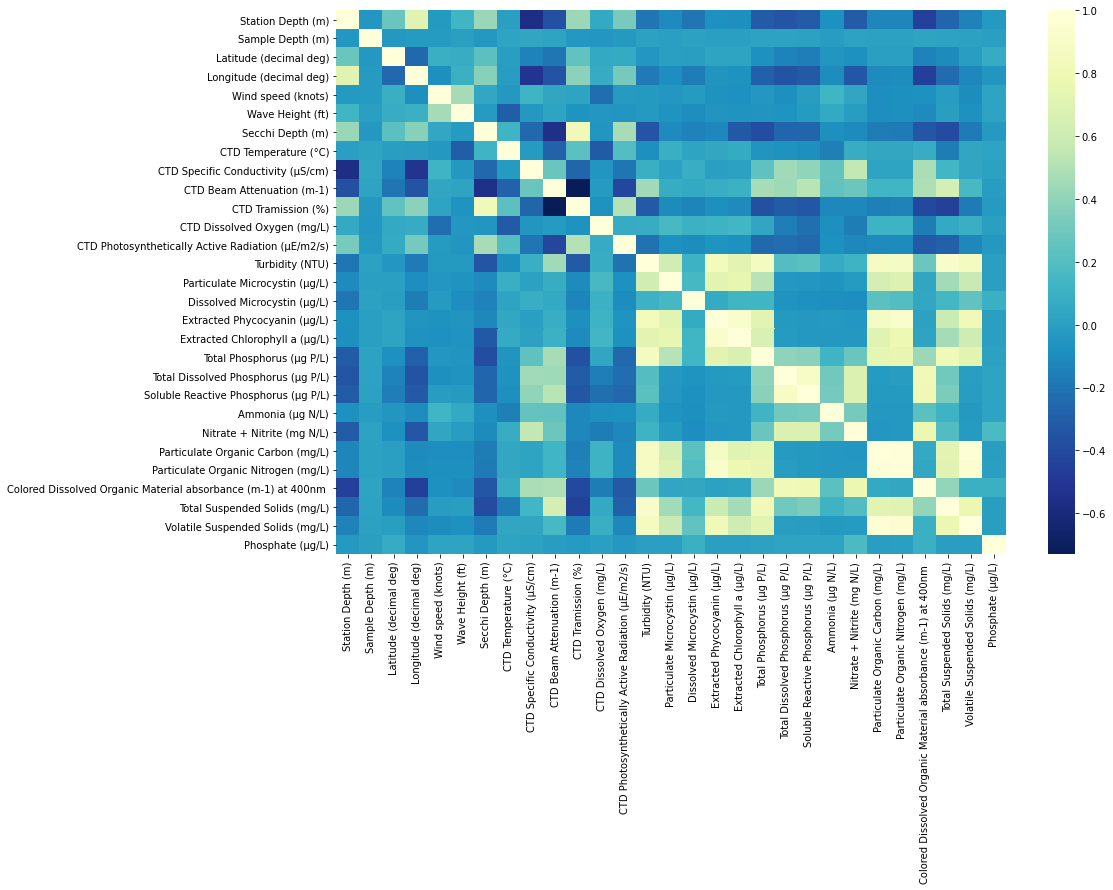

In [7]:
#Visualize the correlations with a heatmap
plt.figure(figsize=(15,10))
sns.heatmap(surface.corr(), cmap='YlGnBu_r')
plt.show()

Some of the correlations in the above heatmap can be explained with straightforward relationships between scientific quantities. For example, transmission and beam attenuation have the defined relationship: 

    c=-(1/r)*ln(%Tr/100) 
    where c=beam attenuation coefficient (m^-1), r=beam path length (m), and Tr=% beam transmission
    
Other relationships are not strictly defined mathematically but are expected. For example, Secchi depth is the depth at which a Secchi disk is no longer visible, which should naturally increase with percent light transmission, and decrease with beam attenuation, increasing turbidity, and increasing particulate matter in the water. Turbidity has a large number of strong positive correlations, which also makes sense since turbidity is simply a measure of the cloudiness of the water, which naturally increases as particulate matter increases, and relates directly to transmission and attenuation.

Quantities indicating the growth of algae, phytoplankton, and cyanobacteria such as Phycocyanin, Chlorophyll, and Particulate Microcystin all have positive correlations with each other, as well as weaker correlations with Turbidity and Total Phosphorus. This may at first seem strange since we know that these creatures consume Phosphorus, but Total Phosphorus should include any phosphorus that was incorporated into the actual algae itself. Note that dissolved forms of Phosphorus do not show any correlation with Phycocyanin, Chlorophyll, or Particulate Microcystin.

Specific conductivity has some weak positive correlations with various chemical quantities of interest, notably Nitrates and Nitrites, Total Dissolved Phosphorus, and Dissolved Organic Material. This could be due to direct effect, as Nitrates and Nitrites are negatively charged anions, and many dissolved forms of phosphorus and organic material are likely also ions. This could also be due to correlation, since N- and P-containing compounds tend to come from runoff or lake inflows that can also carry other ionic compounds (e.g. halides). Interestingly, besides Total Phosphorus it does not seem like nutrients such as the N-containing compounds or soluble P-containing compounds have any notable correlation with Microcystin amounts. In the case of Total Phosphorus as noted above this may very well be because the Total Phosphorus may include intracellular Phosphorus, and would therefore just be another indication of the presence of an HAB, rather than an independent correlated measurement. The lack of correlation between the Microcystin amount and known HAB nutrients is possibly because of the time lag between the establishment of an HAB-friendly environment (warm temperatures, nutrient-rich) and the growth of the HAB itself. Also, as the HAB grows it consumes nutrients, decreasing their amounts until the bloom can no longer be sustained. This suggests that some sort of time series analysis may be necessary.

Interestingly, Temperature and Dissolved Oxygen don't have many strong correlations, despite their importance to aquatic ecosystems. They have a weak correlation with each other - warmer temperatures correlate with less dissolved oxygen, with the plausible mechanistic hypothesis that warmer temperature promote the growth of aerobic organisms that consume oxygen.  Temperature is also naturally correlated with sample depth (deeper samples are colder). 

We can take a closer look at scatterplots of the various correlations.

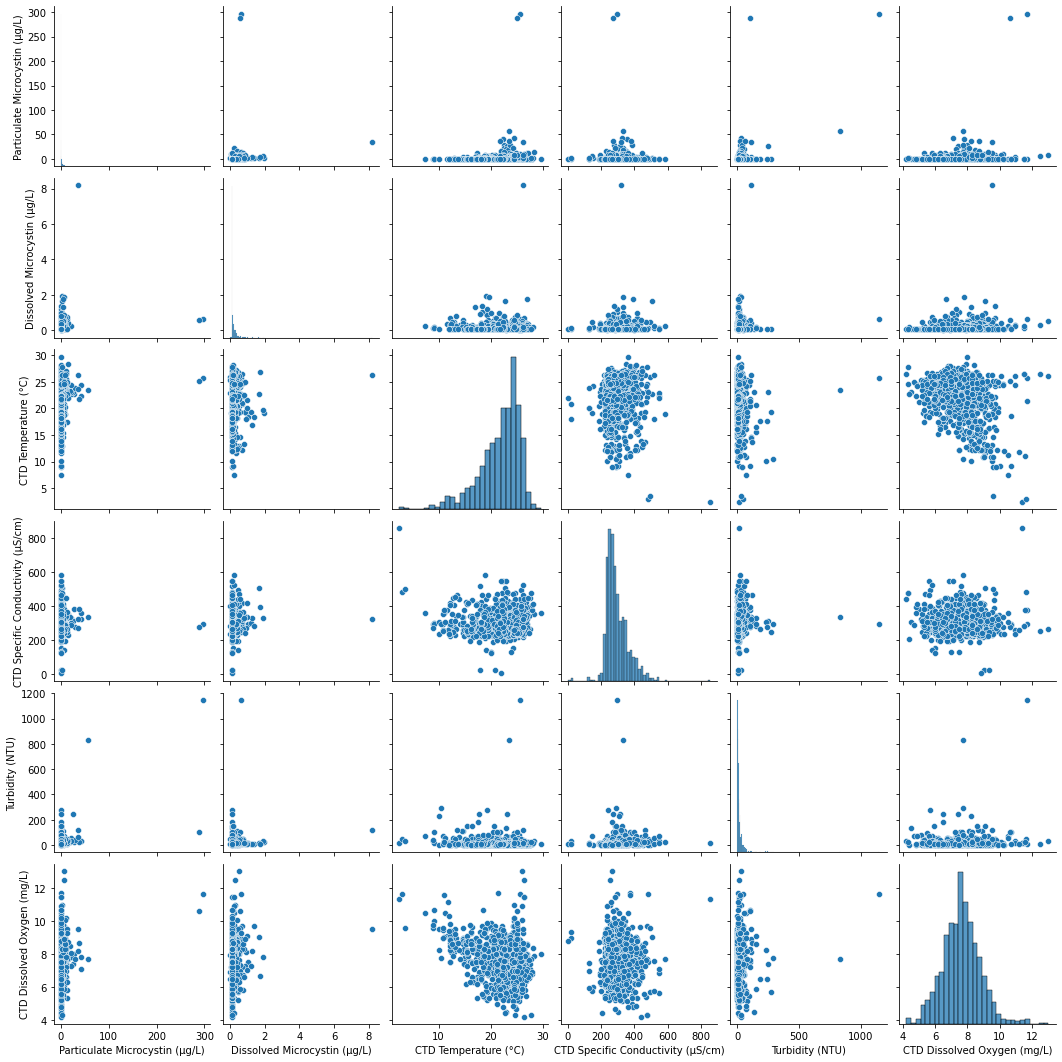

In [8]:
#Pairplot of physical environmental inputs and HAB indicators
sns.pairplot(data=surface,
             vars=['Particulate Microcystin (µg/L)', 'Dissolved Microcystin (µg/L)',
                   'CTD Temperature (°C)', 'CTD Specific Conductivity (µS/cm)', 
                   'Turbidity (NTU)', 'CTD Dissolved Oxygen (mg/L)'])

There are no clear correlations here with the possible exception of the weak negative correlation between temperature and dissolved oxygen.

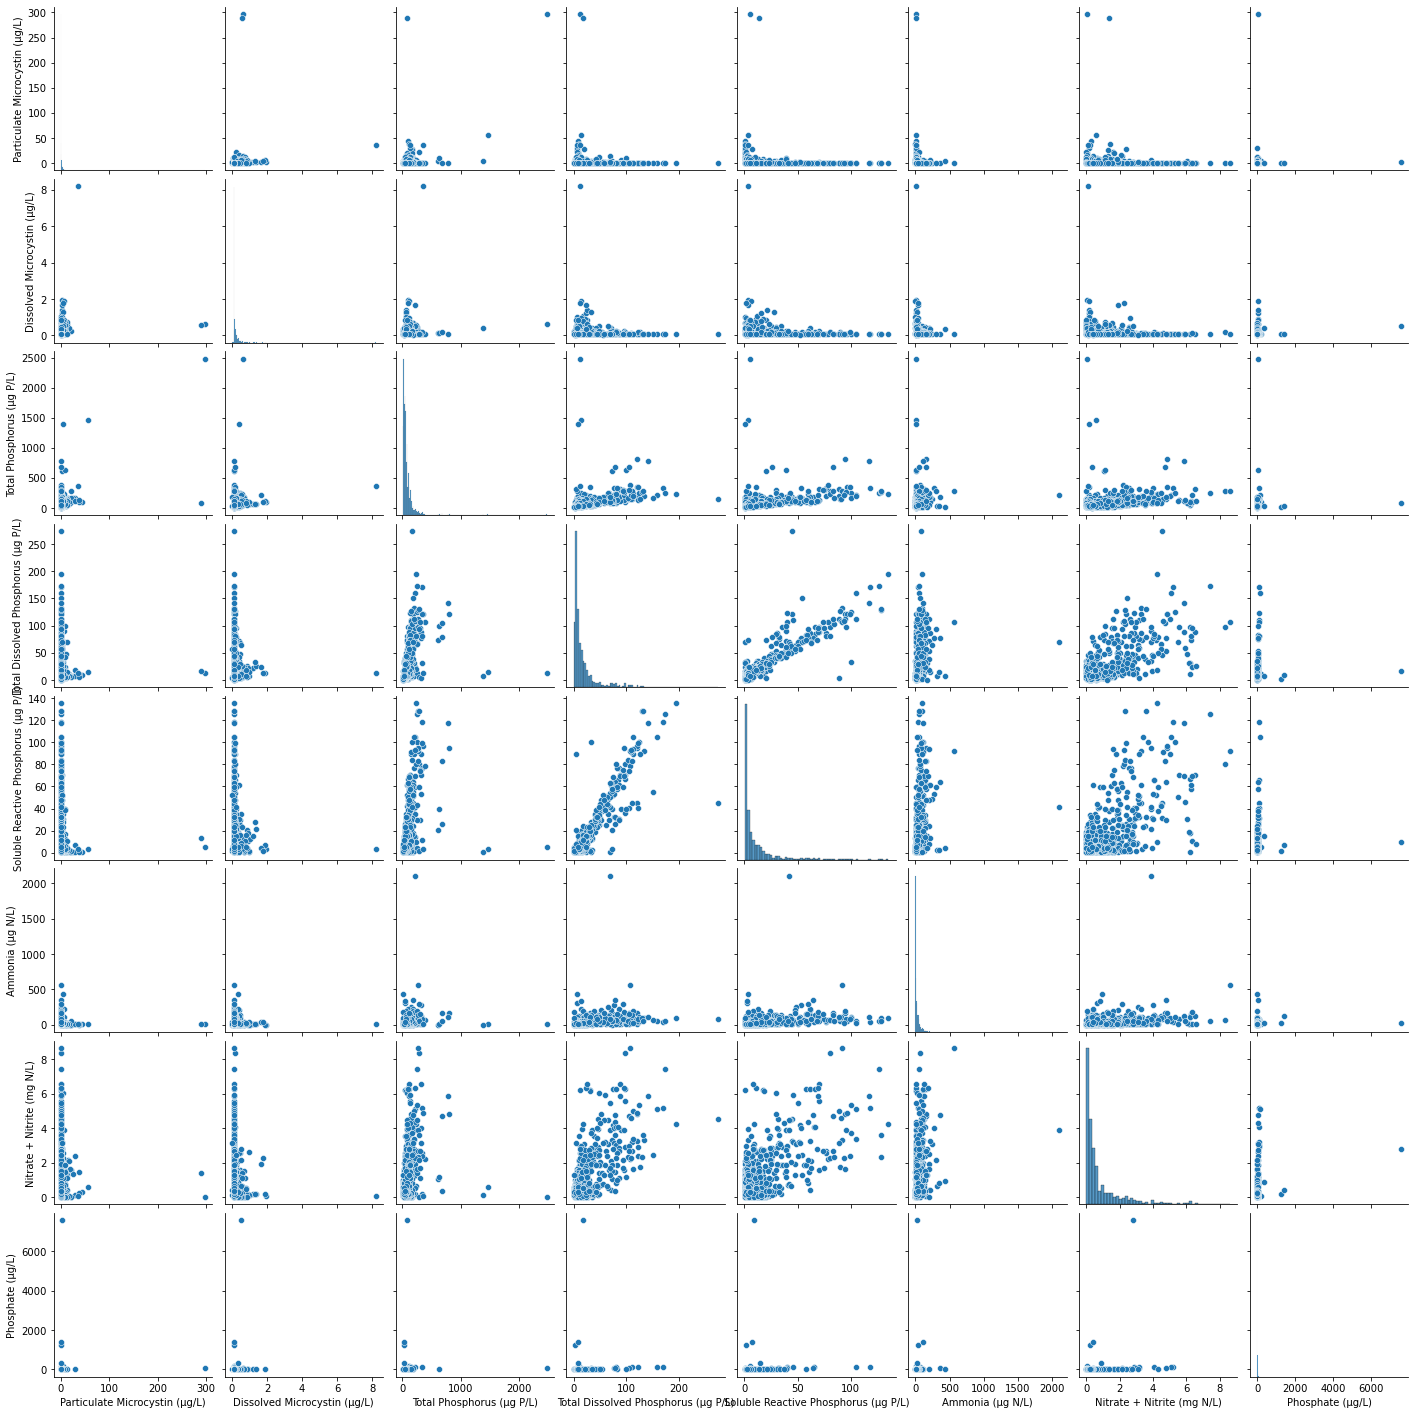

In [9]:
#Pairplot of chemical environmental inputs and HAB indicators
sns.pairplot(data=surface,
             vars=['Particulate Microcystin (µg/L)', 'Dissolved Microcystin (µg/L)', 'Total Phosphorus (µg P/L)', 
                   'Total Dissolved Phosphorus (µg P/L)', 'Soluble Reactive Phosphorus (µg P/L)', 'Ammonia (µg N/L)', 
                   'Nitrate + Nitrite (mg N/L)', 'Phosphate (µg/L)'])

There are some correlations between nutrients that we noted earlier - soluble forms of phosphorus tend to weakly correlate with nitrates and nitrites. Soluble reactive phosphorus is strongly correlated with total dissolved phosphorus. We can also confirm that there is no clear correlation between the microcystin amounts and the nutrient amounts. 

Let's explore the hypothesis of a time lag between favorable HAB growth conditions and HAB indicators. We need to look at how these values vary over time at a given location. First let's see if there are any geographical patterns in where HAB indicators tend to be highest.

In [10]:
#Select data points with top microcystin values. 
top_mcn = surface[surface['Particulate Microcystin (µg/L)'] >= surface['Particulate Microcystin (µg/L)'].quantile(0.9)]

In [11]:
#Map top 10% of microcystin values and color code icons according to particulate microcystin quartiles within that data set. 
mapsites(top_mcn, col='Particulate Microcystin (µg/L)')

It seems the top microcystin measurements tend to be near the shore. This matches intuition on several counts:

1. The water at these locations is shallower and may be expected to reach higher temperatures for longer periods of time.
2. Areas near the shore will have higher concentrations of nutrients due to runoff. In particular the Maumee River that flows into Lake Erie near site WE6 is a major source of nutrient loading into the lake due to agricultural runoff. The river was identified as an area of concern by the EPA 1987 Great Lakes Water Quality Agreement for this reason [<a href='https://19january2017snapshot.epa.gov/maumee-river-aoc_.html'>ref</a>].

We can compare the top 10% of microcystin observations with the bottom 50%.

In [12]:
low_mcn = surface[surface['Particulate Microcystin (µg/L)'] <= surface['Particulate Microcystin (µg/L)'].quantile(0.5)]

In [13]:
mapsites(low_mcn)

These sites tend to be much more evenly distributed and reflective of the general measurement space. 

In [14]:
#Select closely grouped 'WE6' observations
we6 = surface[(surface.Site == 'WE6') & (surface['Latitude (decimal deg)'] < 41.79) 
              & (surface['Longitude (decimal deg)'] > -83.45)]

In [15]:
#Confirm that measurements are within one area
mapsites(we6)

## Time Lag Plots

Is there a discernable time lag in favorable HAB conditions and HAB formation? We can start by visually inspecting the data.

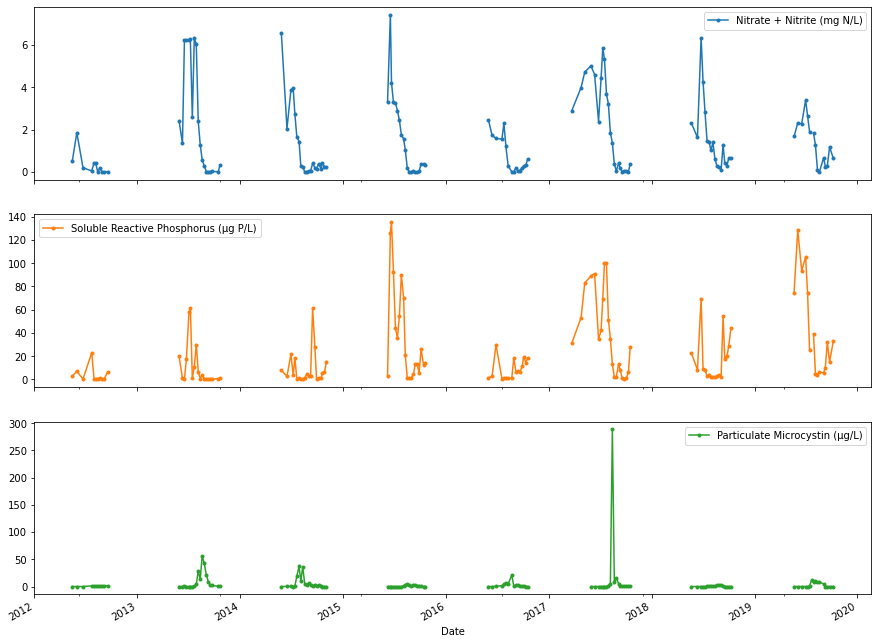

In [16]:
timeplot(we6, ['Nitrate + Nitrite (mg N/L)', 'Soluble Reactive Phosphorus (µg P/L)', 'Particulate Microcystin (µg/L)'], 
         logy=False)

It's a little difficult to see the time-lag here because the spacing between the years compresses each summer of data. We can adjust the plot by using squish=True to only look at recorded dates, and using logy=True to use a log scale on the y-axis.

/Users/melanierbutler/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


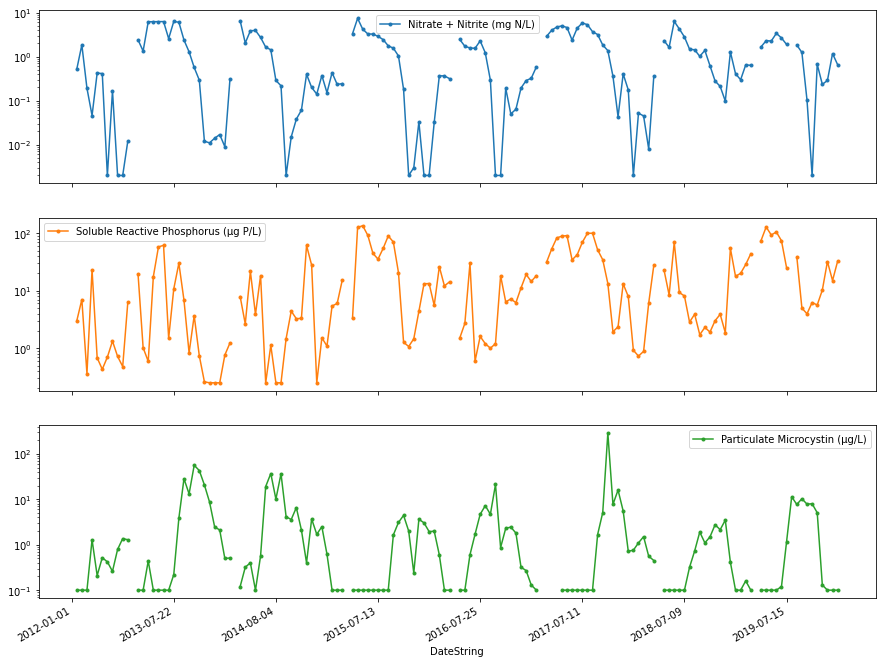

In [17]:
timeplot(we6, ['Nitrate + Nitrite (mg N/L)', 'Soluble Reactive Phosphorus (µg P/L)', 'Particulate Microcystin (µg/L)'], 
         logy=True, squish=True)

/Users/melanierbutler/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


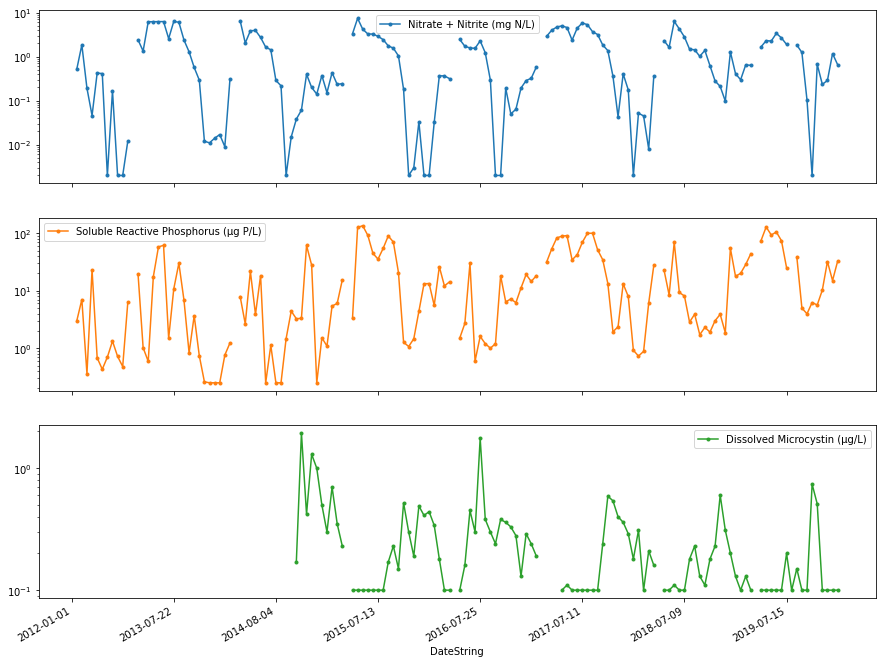

In [18]:
timeplot(we6, ['Nitrate + Nitrite (mg N/L)', 
               'Soluble Reactive Phosphorus (µg P/L)', 
               'Dissolved Microcystin (µg/L)'], 
         logy=True, squish=True)

There certainly appears to be a time lag between nutrient loading and particulate microcystin increase. In fact they seem to alternate with each other. This trend is also present with dissolved microcystin. 

/Users/melanierbutler/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


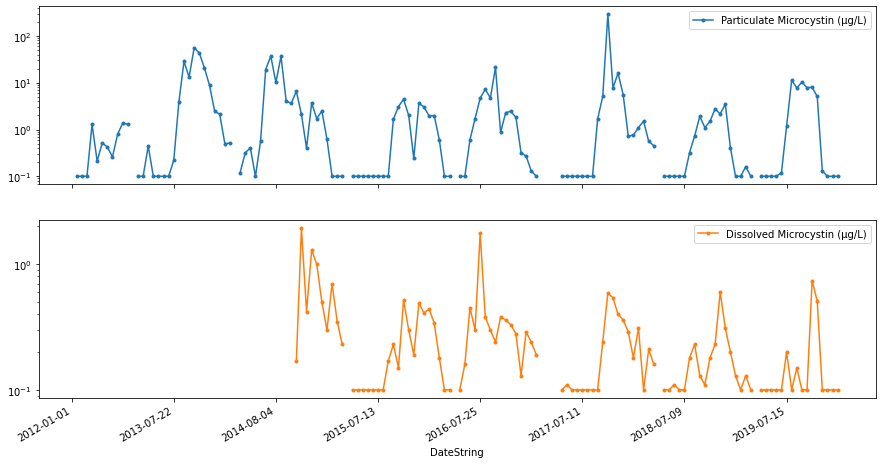

In [19]:
timeplot(we6, ['Particulate Microcystin (µg/L)', 'Dissolved Microcystin (µg/L)'], logy=True, squish=True)

Dissolved and particulate microcystin seem to follow the same trend with no discernable lag in time. This is what we would perhaps expect, although it is not always the case. A USGS study, <a href='https://pubs.usgs.gov/sir/2012/5069/pdf/sir20125069.pdf'>Spatial and Temporal Dynamics of Cyanotoxins and Their Relation to Other Water Quality Variables in Upper Klamath Lake, Oregon, 2007–09</a>, found that dissolved and particulate microcystin did not follow the same exact trend over time. They noted that:

<p style="margin-left:10%; margin-right:10%;">"It is, therefore, difficult to interpret the meaning of the higher percentage of dissolved microcystins that year, particularly because the regulation of toxin production in cyanobacteria is not well understood and the microcystin content of individual cells may be highly variable. However, toxins are released into the water column primarily following death and senescence of a toxigenic bloom, so it is likely that higher dissolved microcystin concentrations in 2008 represent longer or more frequent periods of decline in the microcystin-producing population."</p>

This could suggest that the rise of dissolved microcystin as nutrients fall in the plots above indicates a die-off event.

/Users/melanierbutler/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


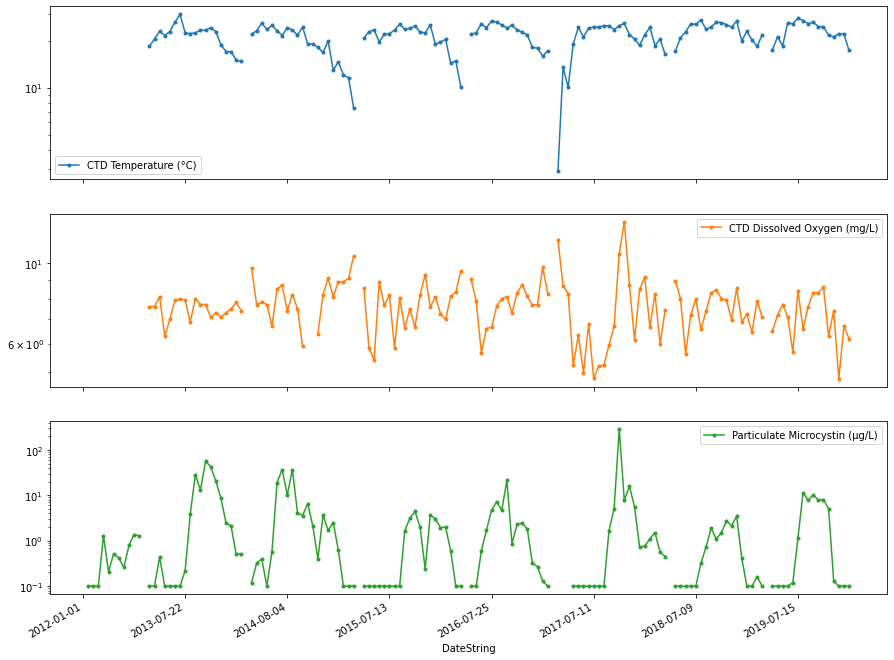

In [20]:
timeplot(we6, ['CTD Temperature (°C)', 
               'CTD Dissolved Oxygen (mg/L)', 
               'Particulate Microcystin (µg/L)'], logy=True, squish=True)

Particulate microcystin rises in late summer, after sustained warm temperatures. It is more difficult to draw meaningful conclusions regarding the relationship between dissolved oxygen, and particulate microcystin. Algae are obligate anaerobes, so they would be expected to die off in the absence of dissolved oxygen. We can examine the Dissolved Microcystin trend for signs of this. 

/Users/melanierbutler/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


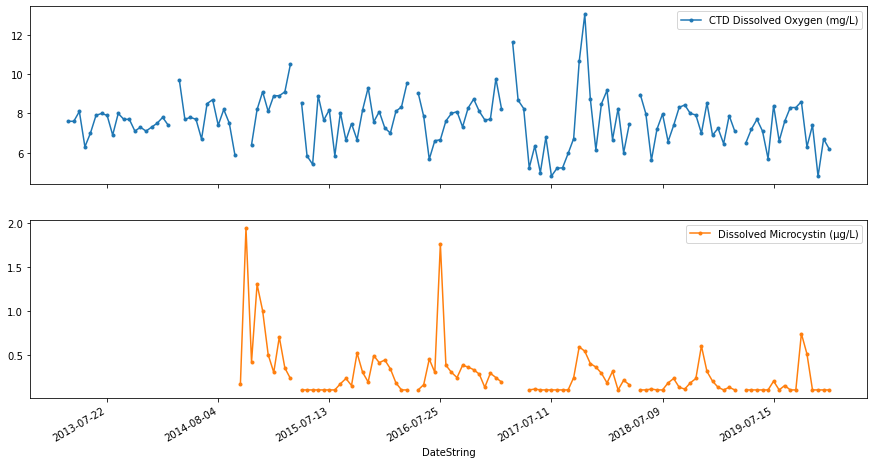

In [21]:
timeplot(we6, ['CTD Dissolved Oxygen (mg/L)', 'Dissolved Microcystin (µg/L)'], logy=False, squish=True)

Again with dissolved microcystin there is no clear relationship. The large peak in July 2016 in dissolved microcystin is preceeded by a sustained drop in dissolved oxygen, which again could suggest oxygen depletion leading to a die-off event and release of microcystin. However, the evidence is not strong enough to lead to any firm conclusions, especially since dissolved oxygen and microcystin seem to trend together in August of 2017. 

Let's examine another site to see if the time lag is consistent across locations.

In [22]:
#Locate WE8 measurements within proximity to each other
we8 = surface[(surface.Site == 'WE8') & (surface['Latitude (decimal deg)'] > 41.71)]

In [23]:
#Confirm that sites are close 
mapsites(we8)

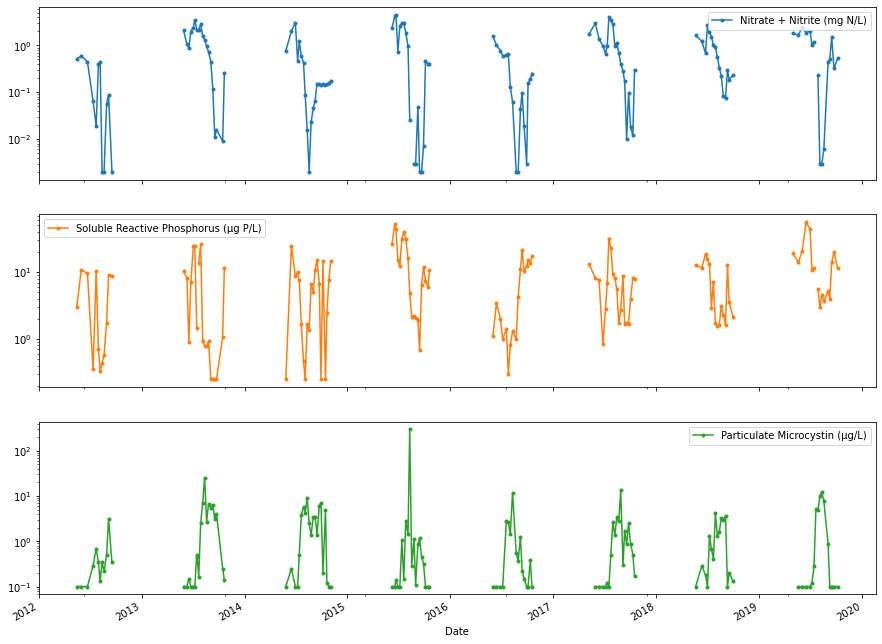

In [24]:
timeplot(we8, ['Nitrate + Nitrite (mg N/L)', 'Soluble Reactive Phosphorus (µg P/L)', 'Particulate Microcystin (µg/L)'],
         logy=True, squish=False)

/Users/melanierbutler/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


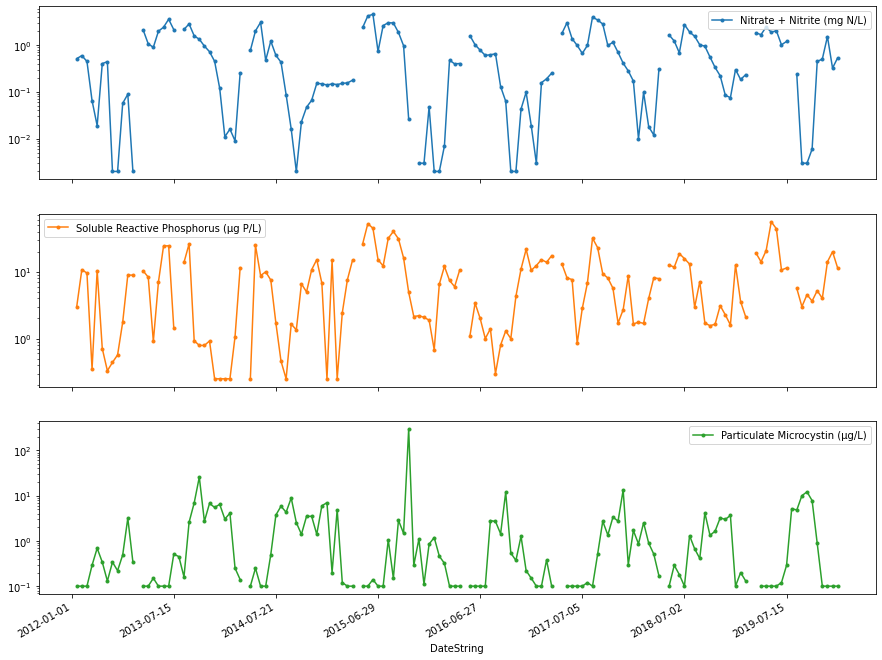

In [25]:
timeplot(we8, ['Nitrate + Nitrite (mg N/L)', 'Soluble Reactive Phosphorus (µg P/L)', 'Particulate Microcystin (µg/L)'],
         logy=True, squish=True)

/Users/melanierbutler/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


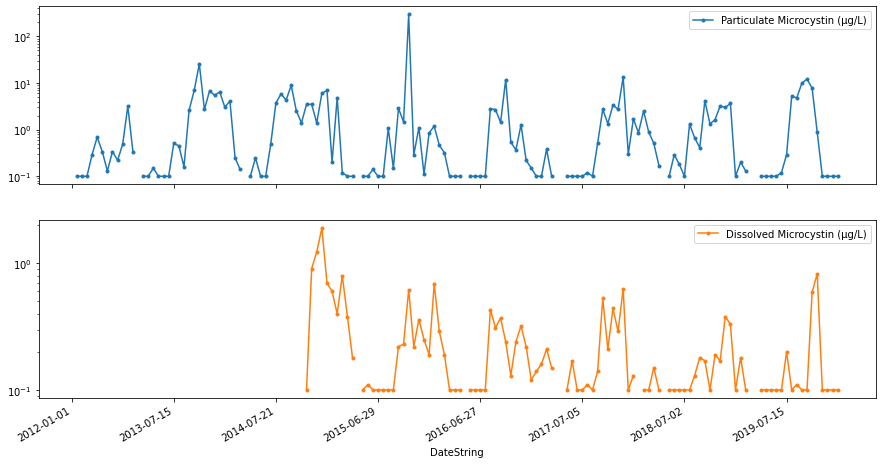

In [26]:
timeplot(we8, ['Particulate Microcystin (µg/L)','Dissolved Microcystin (µg/L)'], logy=True, squish=True)

The WE8 site trends are very similar to those for WE6. It does seem that there is a time lag between favorable HAB conditions and HAB formation.

What about sites that didn't have the highest recorded microcystin measurements?

In [27]:
we13 = surface[(surface.Site == 'WE13') & (surface['Latitude (decimal deg)'] > 41.71) & 
               (surface['Latitude (decimal deg)'] < 41.78) & (surface['Longitude (decimal deg)'] < -83.053)]

In [28]:
#confirm selected sites are close together
mapsites(we13)

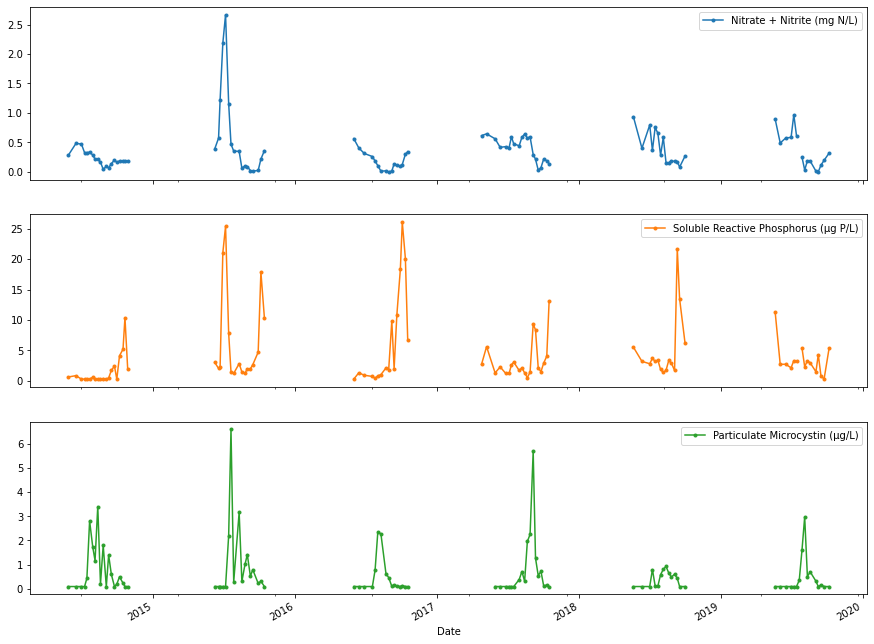

In [29]:
timeplot(we13, ['Nitrate + Nitrite (mg N/L)', 'Soluble Reactive Phosphorus (µg P/L)', 'Particulate Microcystin (µg/L)'],
         logy=False, squish=False)

/Users/melanierbutler/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


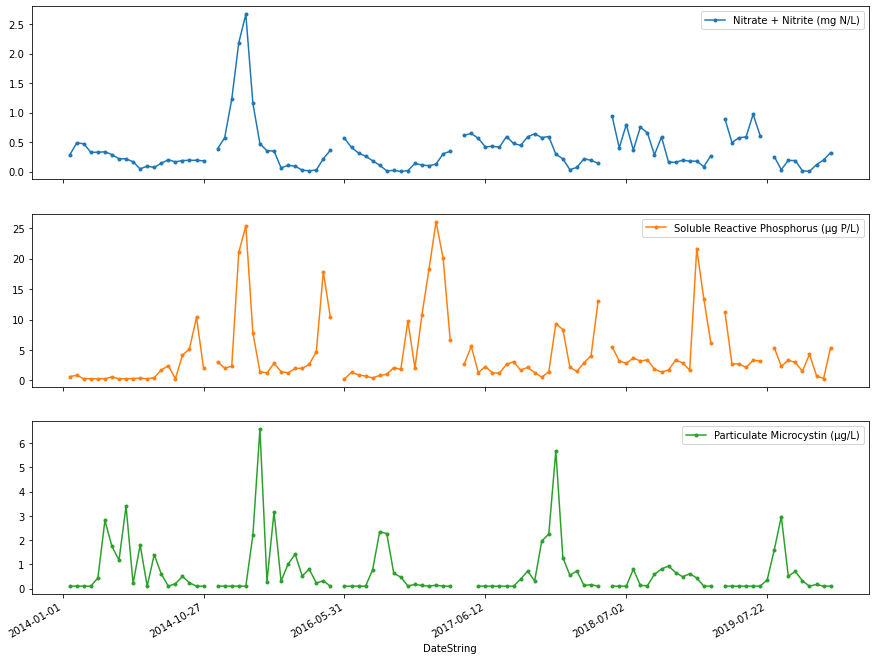

In [30]:
timeplot(we13, ['Nitrate + Nitrite (mg N/L)', 'Soluble Reactive Phosphorus (µg P/L)', 'Particulate Microcystin (µg/L)'],
         logy=False, squish=True)

The apparent lag is less pronounced here, and the range of the measurements in general is less extreme - note that the plots for WE13 are not using a log scale. This makes good intuitive sense if we expect that runoff at the coasts and river inlets are the main sources of nutrient loading. As more heavily polluted waters near the coasts mix with the body of the lake nutrient concentrations should tend to lower and have less fluctuation.

/Users/melanierbutler/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


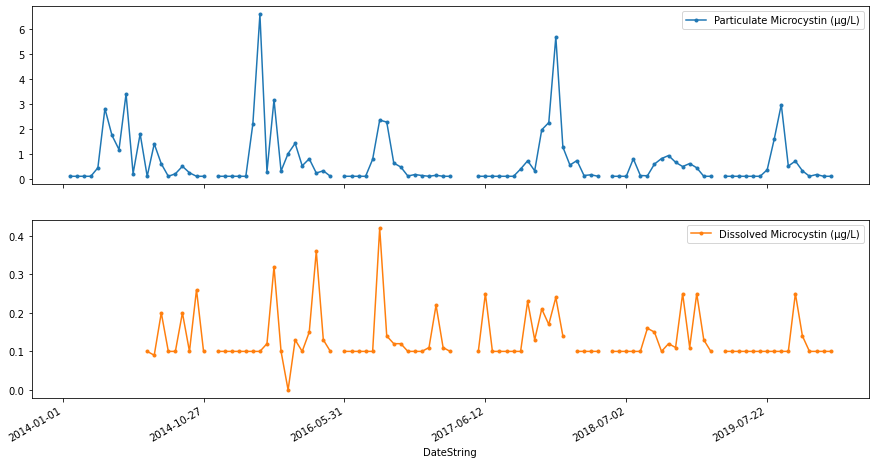

In [31]:
timeplot(we13, ['Particulate Microcystin (µg/L)','Dissolved Microcystin (µg/L)'], logy=False, squish=True)

## Site Difference

Is there a statistically significant difference in quantities of interest at different sites? How should we deal with spatial variability?

We have already selected dataframes for the sites WE6, WE8, and WE13. We can start by comparing WE6 and WE13. 

In [32]:
#difference in location
mapsites(we6.append(we13))

In [33]:
len(we6['Particulate Microcystin (µg/L)'].dropna()), len(we13['Particulate Microcystin (µg/L)'].dropna())

(140, 102)

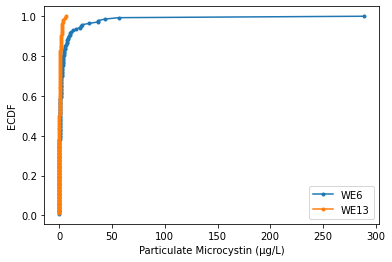

In [34]:
comp_ecdf(we6, we13, 'Particulate Microcystin (µg/L)', name1='WE6', name2='WE13')

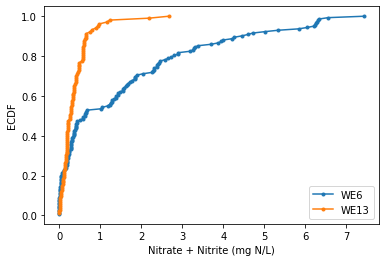

In [35]:
comp_ecdf(we6, we13, 'Nitrate + Nitrite (mg N/L)', name1='WE6', name2='WE13')

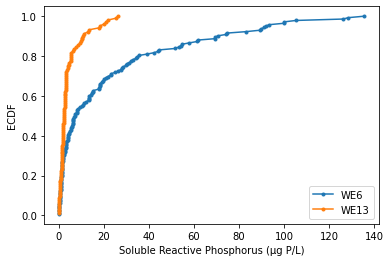

In [36]:
comp_ecdf(we6, we13, 'Soluble Reactive Phosphorus (µg P/L)', name1='WE6', name2='WE13')

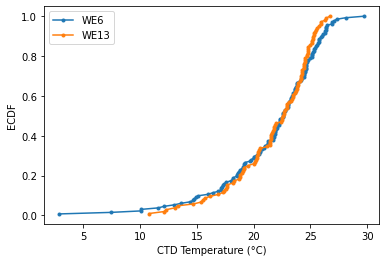

In [37]:
comp_ecdf(we6, we13, 'CTD Temperature (°C)', name1='WE6', name2='WE13')

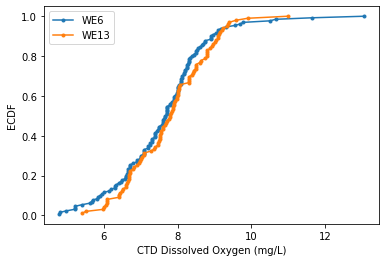

In [38]:
comp_ecdf(we6, we13, 'CTD Dissolved Oxygen (mg/L)', name1='WE6', name2='WE13')

From the ECDFs we can see that WE6 tends to have more of a right tail for all quantities, especialy nitrates and nitrites, and soluble reactive phosphorus. We can use bootstrapping to generate confidence intervals for averages of these quantities, and determine if the means at the different sites are truly different or just due to statistical variation. This requires the assumption that the ~100 observations at each site are representative of the population of measurements at each site, during the months in which samples were collected. 

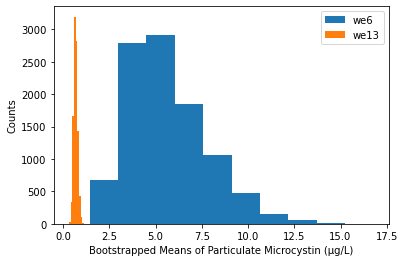

The 95% confidence interval for we6 Particulate Microcystin (µg/L) mean is 2.631267857142857 to 10.456001785714285
The 95% confidence interval for we13 Particulate Microcystin (µg/L) mean is 0.48489950980392166 to 0.902845588235294


In [39]:
bs_hist(we6, we13, 'Particulate Microcystin (µg/L)', name1='we6', name2='we13')

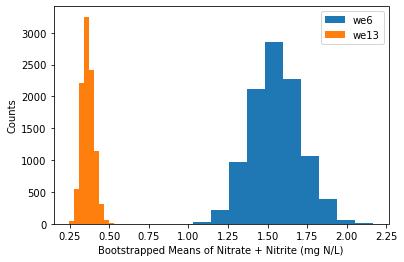

The 95% confidence interval for we6 Nitrate + Nitrite (mg N/L) mean is 1.2590278169014082 to 1.8688080985915494
The 95% confidence interval for we13 Nitrate + Nitrite (mg N/L) mean is 0.29602888349514567 to 0.4444383495145632


In [40]:
bs_hist(we6, we13, 'Nitrate + Nitrite (mg N/L)', name1='we6', name2='we13')

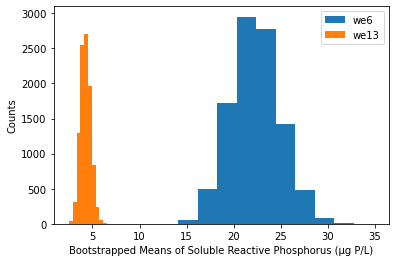

The 95% confidence interval for we6 Soluble Reactive Phosphorus (µg P/L) mean is 17.413225352112676 to 27.608031690140848
The 95% confidence interval for we13 Soluble Reactive Phosphorus (µg P/L) mean is 3.2418201456310682 to 5.4159274271844655


In [41]:
bs_hist(we6, we13, 'Soluble Reactive Phosphorus (µg P/L)', name1='we6', name2='we13')

In [42]:
diff_mean_test(we6, we13, 'Particulate Microcystin (µg/L)')

Difference in observed means is 4.959752100840337. The probability of observing this difference under the null hypothesis is 2.46%.


0.0246

In [43]:
ttest_ind(we6['Particulate Microcystin (µg/L)'].dropna(), 
          we13['Particulate Microcystin (µg/L)'].dropna(), equal_var=False)

Ttest_indResult(statistic=2.3004901795410353, pvalue=0.02290143879169498)

It seems reasonable to reject the null hypothesis and accept that the particulate microcystin means of the two sites are different. 

In [44]:
ttest_ind(we6['Nitrate + Nitrite (mg N/L)'].dropna(), 
          we13['Nitrate + Nitrite (mg N/L)'].dropna(), equal_var=False)

Ttest_indResult(statistic=7.387586153337053, pvalue=8.196166908682048e-12)

In [45]:
diff_mean_test(we6, we13, 'Nitrate + Nitrite (mg N/L)')

Difference in observed means is 1.1916163681115821. The probability of observing this difference under the null hypothesis is 0.0%.


0.0

In [46]:
ttest_ind(we6['Soluble Reactive Phosphorus (µg P/L)'].dropna(), 
          we13['Soluble Reactive Phosphorus (µg P/L)'].dropna(), equal_var=False)

Ttest_indResult(statistic=6.793652468559253, pvalue=2.2684657889721016e-10)

In [47]:
diff_mean_test(we6, we13, 'Soluble Reactive Phosphorus (µg P/L)')

Difference in observed means is 18.03482168740599. The probability of observing this difference under the null hypothesis is 0.0%.


0.0

There is strong statistical evidence for rejecting the null hypothesis for nitrate + nitrite levels and soluble reactive phosphorus. The differences between we6 and we13 suggest that site matters and should be taken into account, either by grouping sites categorically or using some continuous variable that reflects the differences between sites.

What about comparisons between other sites? Or perhaps it would be beneficial to record each site's distance from the Maumee River inlet and/or the shoreline? The shoreline could be a bit more complex, but the distance from the Maumee River inlet would not be difficult. I can also access data on flow and nutrient loading from the Maumee River <a href='https://ncwqr.org/monitoring/'>here</a>.

In [48]:
maumee_inlet = (41.695912, -83.465423)
for i in surface.index:
    coords = (surface.loc[i, 'Latitude (decimal deg)'], surface.loc[i, 'Longitude (decimal deg)'])
    distance = geopy.distance.distance(coords, maumee_inlet).km
    surface.loc[i, 'Distance from Maumee Inlet (km)'] = distance

In [49]:
surface.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987 entries, 0 to 986
Data columns (total 36 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   Date                                                           987 non-null    datetime64[ns]
 1   Site                                                           987 non-null    object        
 2   Station Depth (m)                                              977 non-null    float64       
 3   Sample Depth (m)                                               987 non-null    float64       
 4   Sample Depth (category)                                        987 non-null    object        
 5   Local Time (Eastern Time Zone)                                 981 non-null    object        
 6   Latitude (decimal deg)                                         987 non-null    float64       
 7  

In [50]:
surface['Distance from Maumee Inlet (km)'].describe()

count    987.000000
mean      18.720173
std        9.447484
min        1.078091
25%       13.410052
50%       17.590434
75%       26.894403
max       68.182800
Name: Distance from Maumee Inlet (km), dtype: float64

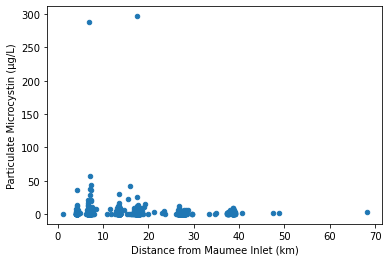

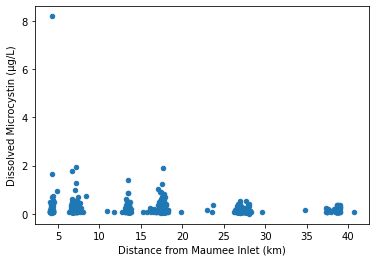

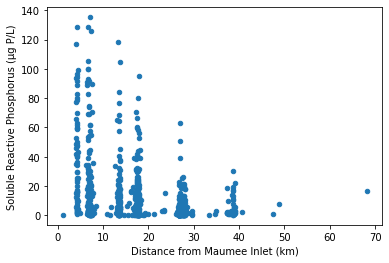

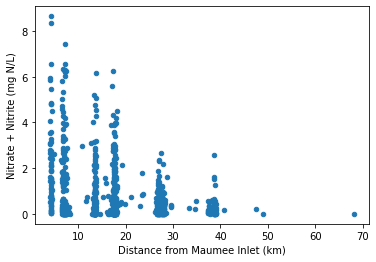

In [51]:
for col in ['Particulate Microcystin (µg/L)', 'Dissolved Microcystin (µg/L)', 'Soluble Reactive Phosphorus (µg P/L)', 
            'Nitrate + Nitrite (mg N/L)']:
    surface.plot(x='Distance from Maumee Inlet (km)', y=col, kind='scatter')

It does seem that sites that are closer to the inlet have a much higher variance, and higher values tend to be at sites located close to the inlet, although there are not very many measurements at distances greater than 40 km, but it seems there are sufficient observations in the 20 to 40 km range.

Perhaps it would be interesting to try to predict seasonal nutrient concentration and subsequent HAB formation based on runoff (rainfall data combined with agricultural land coverage perhaps), nutrient loading from the river, and site location? Agricultural data on land coverage, climate precipitation, temperature,etc can be found through the USDA Natural Resources Conservation Service (data for state of Ohio <a href='https://datagateway.nrcs.usda.gov/GDGOrder.aspx?order=QuickState'>here</a>.

In [52]:
df_0_5 = surface[surface['Distance from Maumee Inlet (km)'] < 5].copy()
df_5_10 = surface[(surface['Distance from Maumee Inlet (km)'] >= 5) & (surface['Distance from Maumee Inlet (km)'] < 10)].copy()
df_10_15 = surface[(surface['Distance from Maumee Inlet (km)'] >= 10) & (surface['Distance from Maumee Inlet (km)'] < 15)].copy()
df_15_20 = surface[(surface['Distance from Maumee Inlet (km)'] >= 15) & (surface['Distance from Maumee Inlet (km)'] < 20)].copy()
df_20_30 = surface[(surface['Distance from Maumee Inlet (km)'] >= 20) & (surface['Distance from Maumee Inlet (km)'] < 30)].copy()
df_30_40 = surface[(surface['Distance from Maumee Inlet (km)'] >= 30) & (surface['Distance from Maumee Inlet (km)'] < 40)].copy()

In [53]:
distance_dfs = [df_0_5, df_5_10, df_10_15, df_15_20, df_20_30, df_30_40]
distance_names = ['0 to 5 km', '5 to 10 km', '10 to 15 km', '15 to 20 km', '20 to 30 km', '30 to 40 km']
for df, name in zip(distance_dfs, distance_names):
    print(name + ':\n' + str(df.Site.value_counts()) + '\n')

0 to 5 km:
WE9    69
WE6     1
Name: Site, dtype: int64

5 to 10 km:
WE6        143
Unknown      1
WE8          1
Name: Site, dtype: int64

10 to 15 km:
WE2        139
Unknown      5
WE12         1
WE6          1
Name: Site, dtype: int64

15 to 20 km:
WE8        143
WE12       111
Unknown      7
WE2          3
WE6          2
WE9          1
WE15         1
Name: Site, dtype: int64

20 to 30 km:
WE4        145
WE13       106
WE16        31
Unknown      9
WE15         1
WE12         1
WE2          1
Name: Site, dtype: int64

30 to 40 km:
WE15       44
WE14       13
Unknown     2
WE13        1
Name: Site, dtype: int64



This seems to separate the sites out fairly well, with each grouping consisting of mainly one or two sites. Are the sites that are grouped together by distance similar to each other?

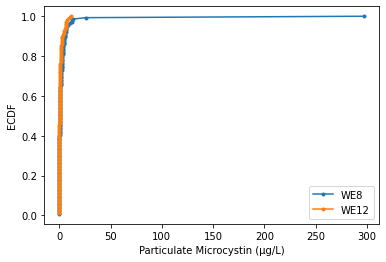

In [54]:
#Sites WE8 and WE12 are grouped together in the 15 to 20 km category. Are they truly similar?
comp_ecdf(df_15_20[df_15_20.Site == 'WE8'], df_15_20[df_15_20.Site=='WE12'], 'Particulate Microcystin (µg/L)', 
          name1='WE8', name2='WE12')

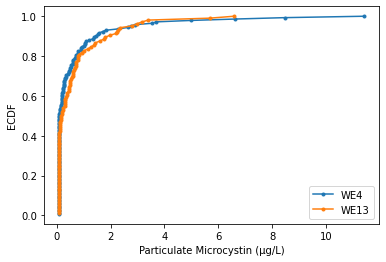

0.8934854053212739

In [55]:
#Sites WE4 and WE13 are grouped together in the 20 to 30 km category. Are they truly similar?
comp_ecdf(df_20_30[df_20_30.Site == 'WE4'], df_20_30[df_20_30.Site=='WE13'], 'Particulate Microcystin (µg/L)', 
          name1='WE4', name2='WE13')
ttest_ind(df_20_30[df_20_30.Site == 'WE4']['Particulate Microcystin (µg/L)'].dropna(), 
                             df_20_30[df_20_30.Site=='WE13']['Particulate Microcystin (µg/L)'].dropna(), equal_var=False).pvalue

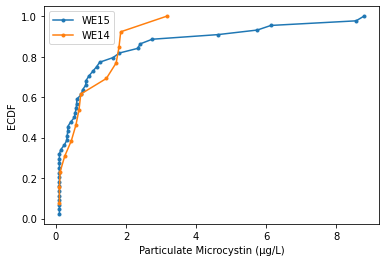

0.41401353514618133

In [56]:
#Sites WE15 and WE14 are grouped together in the 30 to 40 km category. Are they truly similar?
comp_ecdf(df_30_40[df_30_40.Site == 'WE15'], df_30_40[df_30_40.Site=='WE14'], 'Particulate Microcystin (µg/L)', 
          name1='WE15', name2='WE14')
ttest_ind(df_30_40[df_30_40.Site == 'WE15']['Particulate Microcystin (µg/L)'].dropna(), 
                             df_30_40[df_30_40.Site=='WE14']['Particulate Microcystin (µg/L)'].dropna(), equal_var=False).pvalue

The groupings seem justified based on the similarity of the ECDFs except for the 30 to 40 km category, although this does not contain many data points. Let's check if there is a difference between distance groupings.

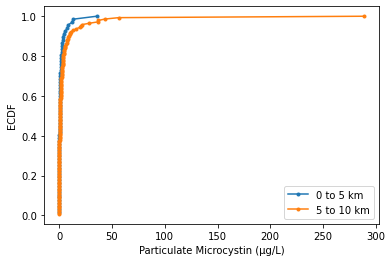

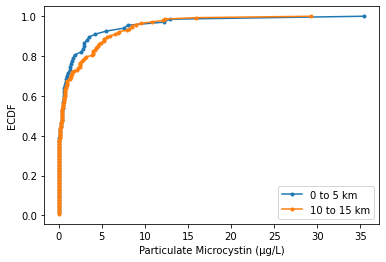

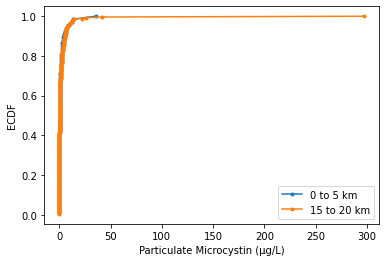

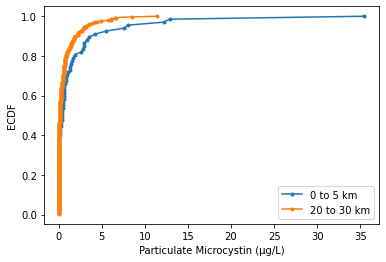

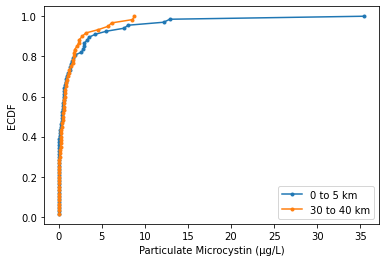

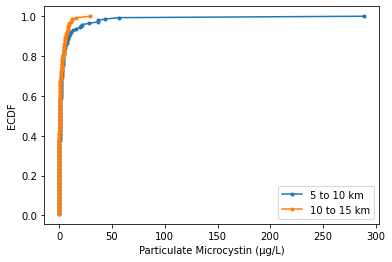

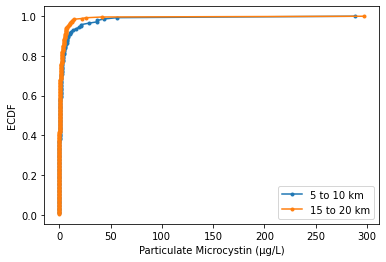

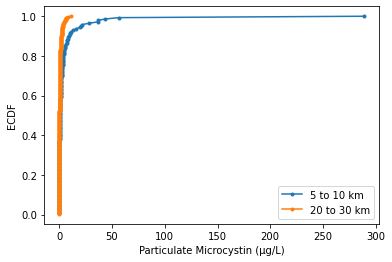

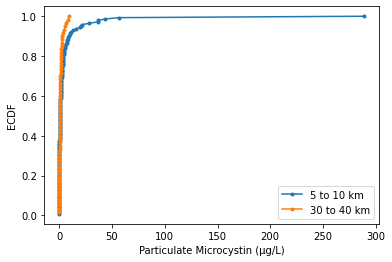

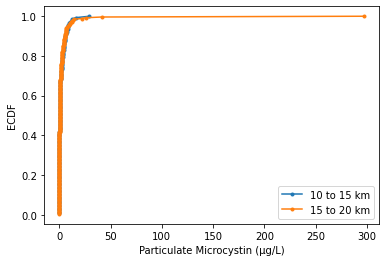

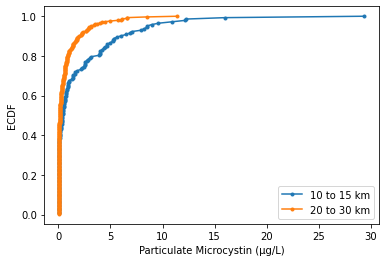

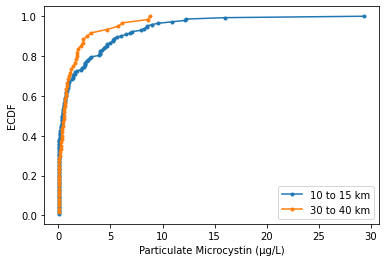

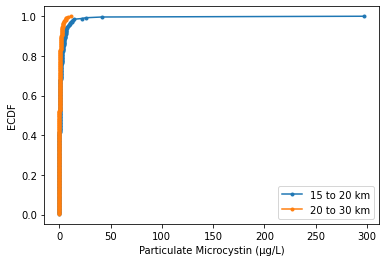

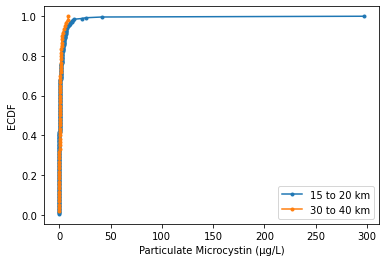

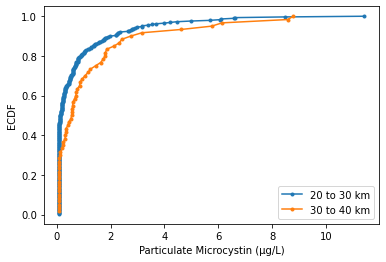

In [57]:
for i, (df1, name1) in enumerate(zip(distance_dfs, distance_names)):
        for df2, name2 in zip(distance_dfs[i+1:], distance_names[i+1:]):
            comp_ecdf(df1, df2, 'Particulate Microcystin (µg/L)', name1=name1, name2=name2)

Some of the distance groupings look significantly different based on the ECDFs (e.g. 10 to 15 km vs 20 to 30 km) whereas others look almost identical (0 to 5 km and 15 to 20 km). We can also look at p-values using an independent t-test for each distance grouping.

In [58]:
def distance_pvals(col):    
    col_pvals = dict()
    for df1, name1 in zip(distance_dfs, distance_names):
        pvals = []
        for df2, name2 in zip(distance_dfs, distance_names):
            pval = ttest_ind(df1[col].dropna(), 
                             df2[col].dropna(), equal_var=False).pvalue
            pvals.append(pval)
        col_pvals[name1] = pvals

    col_pvals_df = pd.DataFrame(col_pvals, index=distance_names)
    return col_pvals_df

<AxesSubplot:>

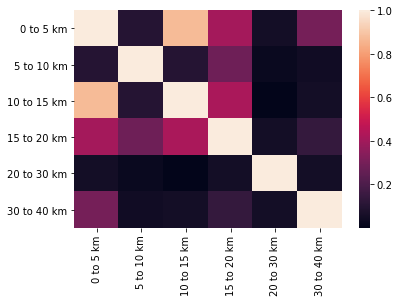

In [59]:
sns.heatmap(distance_pvals('Particulate Microcystin (µg/L)'))

<AxesSubplot:>

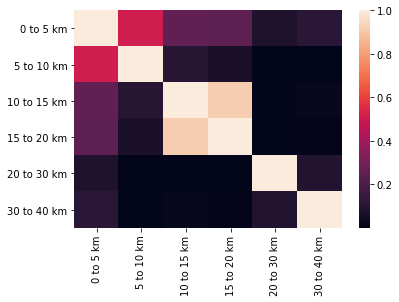

In [60]:
sns.heatmap(distance_pvals('Dissolved Microcystin (µg/L)'))

<AxesSubplot:>

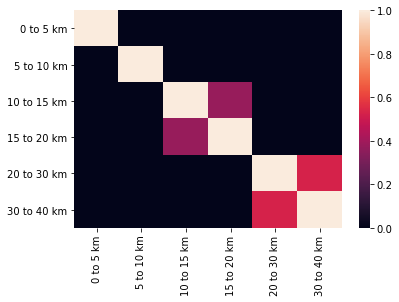

In [61]:
sns.heatmap(distance_pvals('Soluble Reactive Phosphorus (µg P/L)'))

<AxesSubplot:>

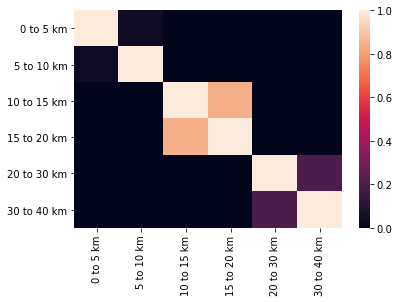

In [62]:
sns.heatmap(distance_pvals('Nitrate + Nitrite (mg N/L)'))

Different distance groupings seem to have low p-values for nutrient concentrations (nitrates + nitrites and soluble phosphorus) which indicates stronger evidence for rejecting the null hypothesis that different distance groupings actually have the same averages for those quantities. Interestingly, there does not seem to be evidence for rejecting the null hypothesis for most distance groupings for particulate microcystin. Note that the two sites we previously compared, we6 and we13, fall in the '5 to 10 km' and '20 to 30 km' distances respectively, which have low p-values for all quantities including particulate microcystin.

In [63]:
surface.Site.value_counts()

WE6        147
WE4        145
WE8        144
WE2        143
WE12       113
WE13       107
WE9         70
WE15        46
WE16        31
Unknown     27
WE14        14
Name: Site, dtype: int64

In [64]:
we4 = surface[(surface.Site=='WE4') & (surface['Latitude (decimal deg)'] > 41.78)]
we2 = surface[(surface.Site=='WE2') & (surface['Latitude (decimal deg)'] < 41.79) & (surface['Longitude (decimal deg)'] < -83.28)]
we12 = surface[(surface.Site=='WE12') & (surface['Longitude (decimal deg)'] > -83.34) & (surface['Longitude (decimal deg)'] < -83.14)]
we9 = surface[(surface.Site=='WE9') & (surface['Longitude (decimal deg)'] < -83.26)]
we15 = surface[(surface.Site=='WE15') & (surface['Longitude (decimal deg)'] > -83.14)]
we16 = surface[(surface.Site=='WE16')]
we14 = surface[surface.Site=='WE14']

#redefine we6, we8, and we13 to include new surface column - distance from maumee inlet
we6 = surface[(surface.Site == 'WE6') & (surface['Latitude (decimal deg)'] < 41.79) & (surface['Longitude (decimal deg)'] > -83.45)]
we8 = surface[(surface.Site == 'WE8') & (surface['Latitude (decimal deg)'] > 41.71)]
we13 = surface[(surface.Site == 'WE13') & (surface['Latitude (decimal deg)'] > 41.71) & 
               (surface['Latitude (decimal deg)'] < 41.78) & (surface['Longitude (decimal deg)'] < -83.053)]

In [65]:
mapsites(we14)

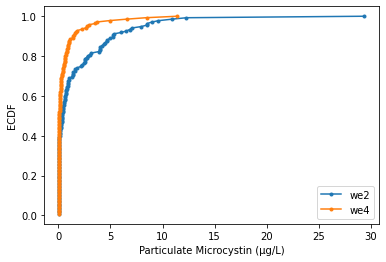

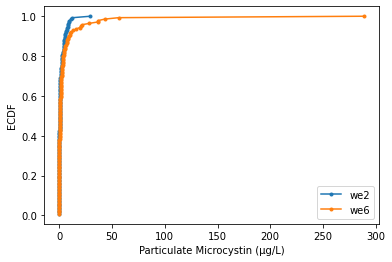

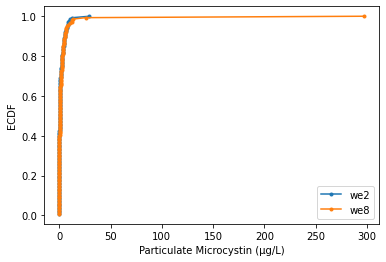

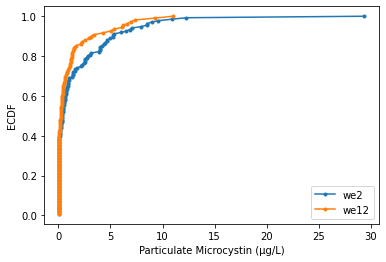

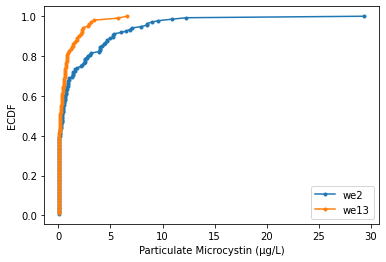

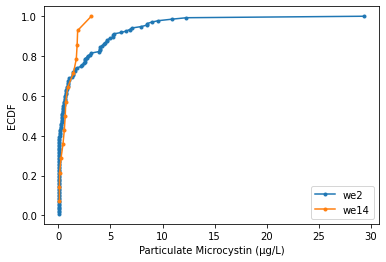

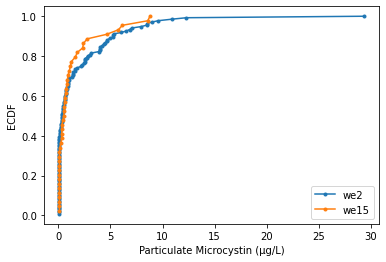

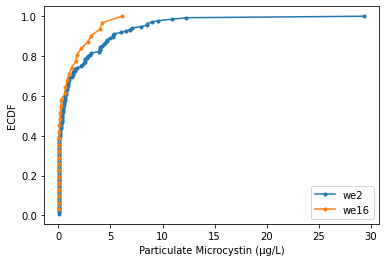

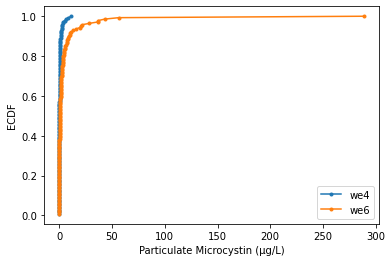

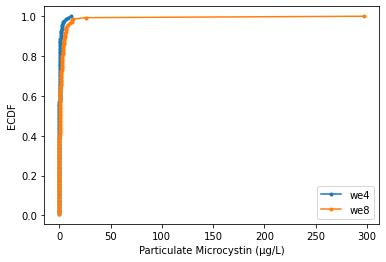

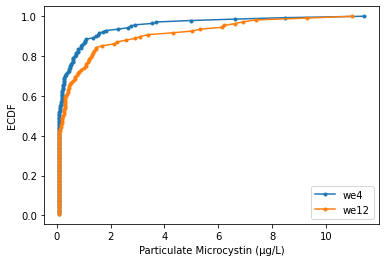

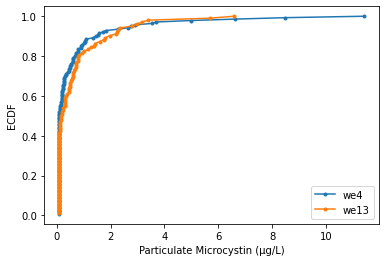

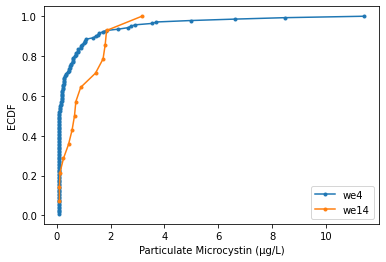

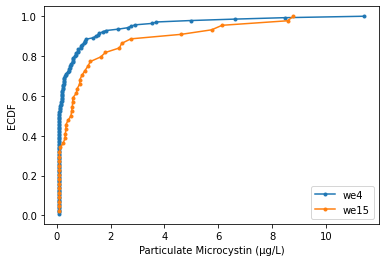

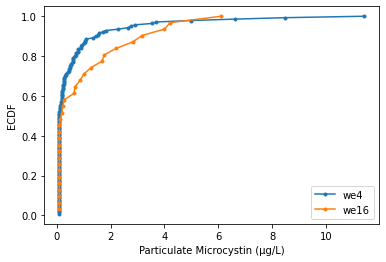

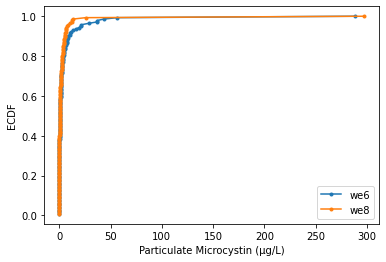

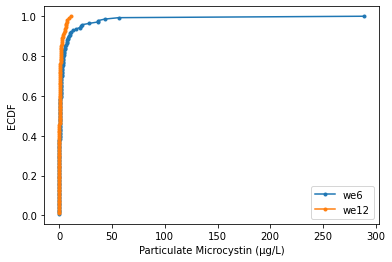

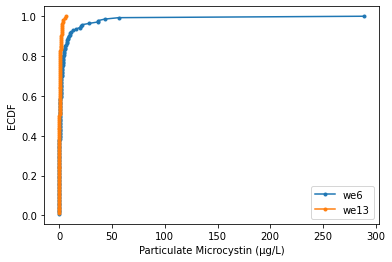

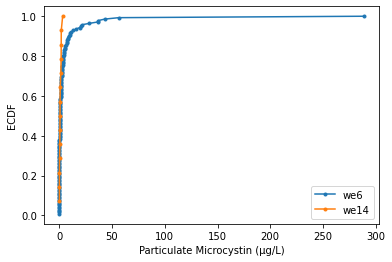

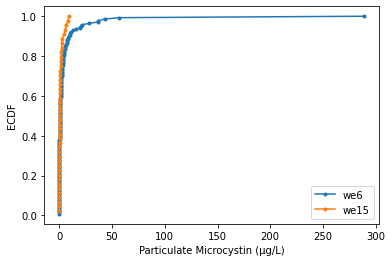

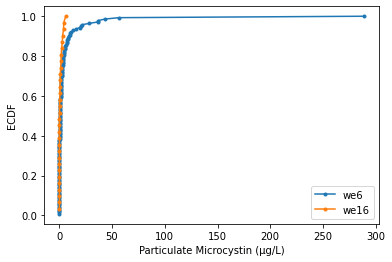

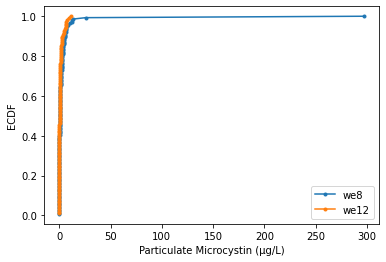

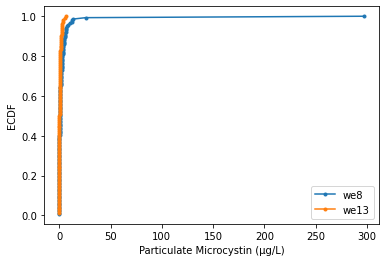

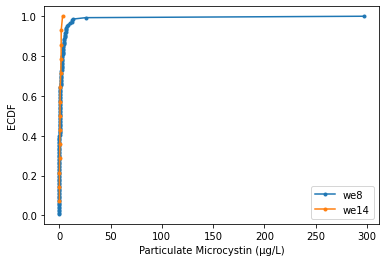

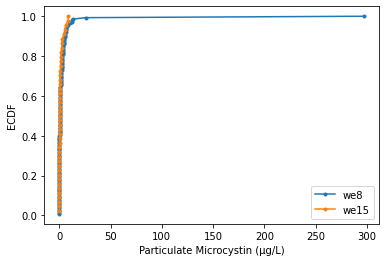

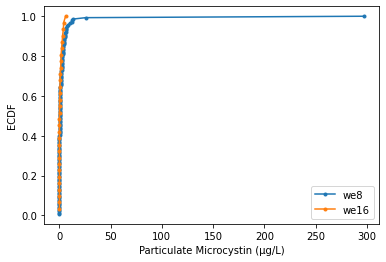

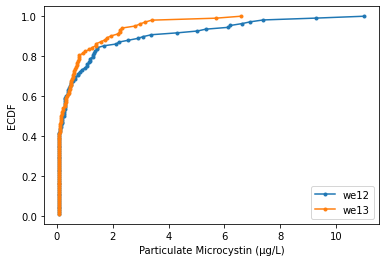

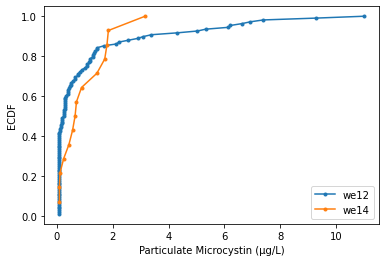

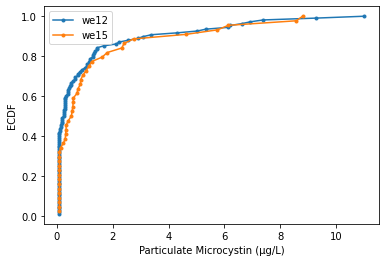

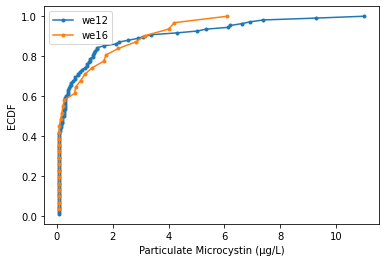

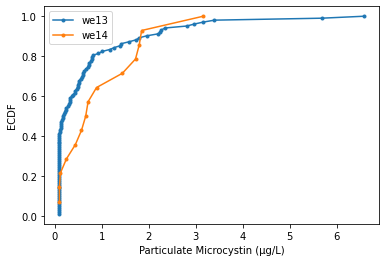

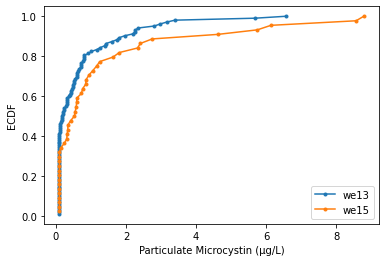

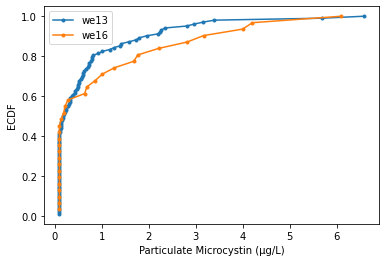

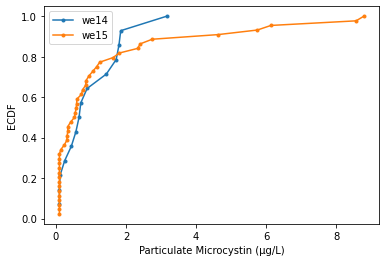

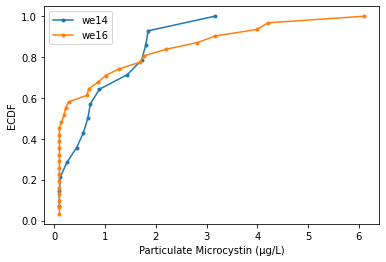

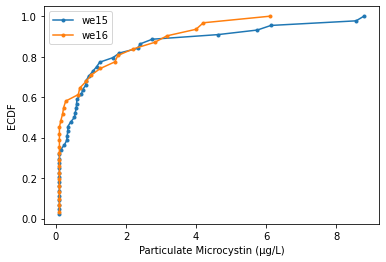

In [66]:
sites = [we2, we4, we6, we8, we12, we13, we14, we15, we16]
site_names = ['we2', 'we4', 'we6', 'we8', 'we12', 'we13', 'we14', 'we15', 'we16']

for i, (site1, name1) in enumerate(zip(sites, site_names)):
        for site2, name2 in zip(sites[i+1:], site_names[i+1:]):
            comp_ecdf(site1, site2, 'Particulate Microcystin (µg/L)', name1=name1, name2=name2)

In [67]:
for site in sites:
    print(len(site))

139
142
143
143
111
104
14
44
31


In [68]:
def site_pvals(col):    
    col_pvals = dict()
    for site1, name1 in zip(sites, site_names):
        pvals = []
        for site2, name2 in zip(sites, site_names):
            pval = ttest_ind(site1[col].dropna(), 
                             site2[col].dropna(), equal_var=False).pvalue
            pvals.append(pval)
        col_pvals[name1] = pvals

    col_pvals_df = pd.DataFrame(col_pvals, index=site_names)
    return col_pvals_df

<AxesSubplot:>

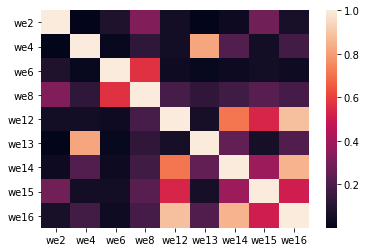

In [69]:
sns.heatmap(site_pvals('Particulate Microcystin (µg/L)'))

Most sites do not seem to be significantly different from each other. The distance from the Maumee river seems more influential than exact site location in terms of the average amount of particulate microcystin.

In [70]:
sites_df = pd.concat(sites, ignore_index=True)
sites_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 36 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   Date                                                           871 non-null    datetime64[ns]
 1   Site                                                           871 non-null    object        
 2   Station Depth (m)                                              864 non-null    float64       
 3   Sample Depth (m)                                               871 non-null    float64       
 4   Sample Depth (category)                                        871 non-null    object        
 5   Local Time (Eastern Time Zone)                                 866 non-null    object        
 6   Latitude (decimal deg)                                         871 non-null    float64       
 7  

## Time Lag Magnitude Estimation

What is the distribution of time lags from peak favorable HAB conditions to peak HAB indicators?

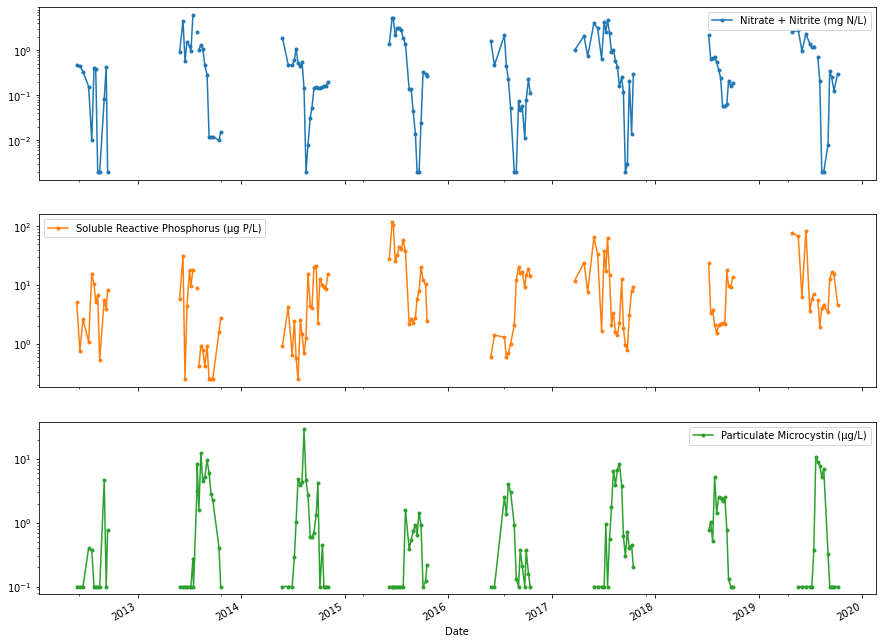

In [71]:
timeplot(we2, ['Nitrate + Nitrite (mg N/L)','Soluble Reactive Phosphorus (µg P/L)', 
               'Particulate Microcystin (µg/L)'], logy=True)

It is not easy to read from the graph, and the data is somewhat noisy. We can try to smoothe it a bit by taking a rolling average.

In [72]:
we2rolling = we2[['Nitrate + Nitrite (mg N/L)',
                  'Particulate Microcystin (µg/L)']].rolling(window=3).mean()

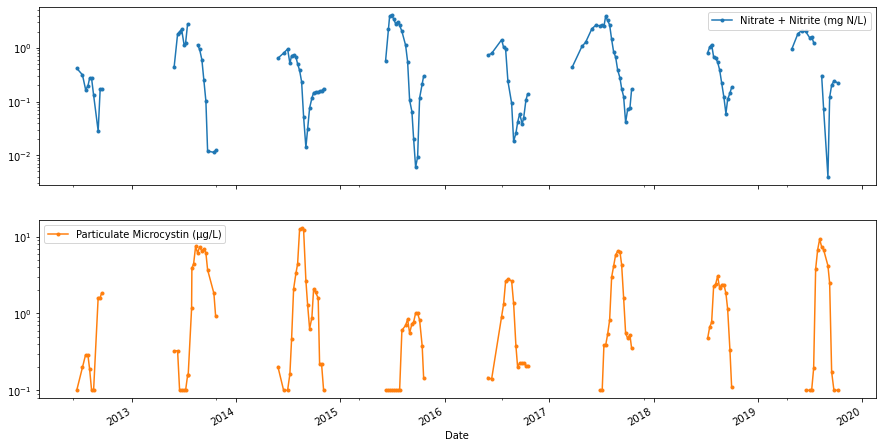

In [73]:
timeplot(we2[['Date']].join(we2rolling), ['Nitrate + Nitrite (mg N/L)', 
                                          'Particulate Microcystin (µg/L)'], logy=True)

It is still difficult to quantify the time lag in an objective way. To keep things simple at this stage we can simply look at the point at which each feature reaches its maximum value in one year cycle, and look at the time lag between features. This is not necessarily the best way to determine time lag. For one thing, local maxima within the year may be more relevant in some cases than the yearly global maxima. Because nutrient features sometimes recover at the end of a season after the microcystin decreases we can't guarantee that we won't get negative time lags in that case. A more nuanced approach would perhaps fit the data and look at the first derivative of the features in each year, to determine the lag in when nutrient features begin to fall and when particulate microcystin begins to rise. However, a simple start will at least give us some idea of the lag distribution.

In [74]:
#Try out timelag on the we2 site data
we2deltat = timelag(we2[['Date']].join(we2rolling), 'Nitrate + Nitrite (mg N/L)', 'Particulate Microcystin (µg/L)')
we2deltat

[Timedelta('87 days 00:00:00'),
 Timedelta('28 days 00:00:00'),
 Timedelta('49 days 00:00:00'),
 Timedelta('84 days 00:00:00'),
 Timedelta('22 days 00:00:00'),
 Timedelta('42 days 00:00:00'),
 Timedelta('21 days 00:00:00'),
 Timedelta('63 days 00:00:00')]

In [75]:
#Average time lag
np.mean(we2deltat)

Timedelta('49 days 12:00:00')

In [76]:
#Function smoothes each site, calculates time lags and appends them to a time lag list for all sites.
def sitelags(col1, col2, window=3):
    sitedeltas = []
    for name, site in zip(site_names, sites):
        df = site[['Date']].join(site[[col1, col2]].rolling(window=window).mean())
        deltat = timelag(df, col1, col2)
        sitedeltas += deltat
    return sitedeltas

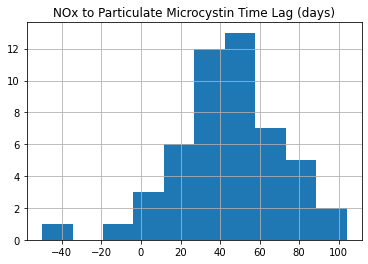

NOx to Particulate Microcystin Time Lag (days)
count                                       48.000000
mean                                        47.583333
std                                         24.692865
min                                          0.000000
25%                                         28.000000
50%                                         46.000000
75%                                         63.000000
max                                        104.000000

In [77]:
#NOx data
Ndeltas = sitelags('Nitrate + Nitrite (mg N/L)', 'Particulate Microcystin (µg/L)')
Ndf = pd.DataFrame({'NOx to Particulate Microcystin Time Lag (days)': Ndeltas}).astype('timedelta64[D]')
Ndf.hist()
plt.show()
Ndf[Ndf >= 0].describe()

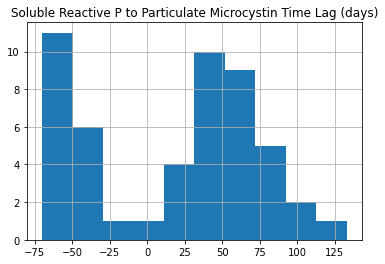

Soluble Reactive P to Particulate Microcystin Time Lag (days)
count                                          32.000000            
mean                                           56.906250            
std                                            28.300643            
min                                             0.000000            
25%                                            35.000000            
50%                                            56.000000            
75%                                            72.250000            
max                                           133.000000

In [78]:
#Soluble reactive phosphorus data
Pdeltas = sitelags('Soluble Reactive Phosphorus (µg P/L)', 'Particulate Microcystin (µg/L)')
Pdf = pd.DataFrame({'Soluble Reactive P to Particulate Microcystin Time Lag (days)': Pdeltas}).astype('timedelta64[D]')
Pdf.hist()
plt.show()
Pdf[Pdf >= 0].describe()

Both of the NOx and Soluble Reactive Phosphorus time lags are what we would expect based on earlier visual inspection of select time plots. There are many instances of 'negative' time lags, due to the issues with global maxima discussed earlier. If we focus on the distributions for positive time lags we can see they tend to range from one to two and a half months, with medians in the six week range.

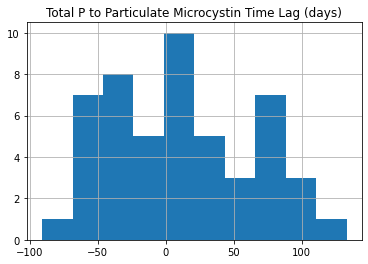

Total P to Particulate Microcystin Time Lag (days)
count                                          50.000000 
mean                                           10.600000 
std                                            53.721504 
min                                           -91.000000 
25%                                           -28.000000 
50%                                             0.000000 
75%                                            59.500000 
max                                           133.000000

In [79]:
#Total phosphorus data
TPdeltas = sitelags('Total Phosphorus (µg P/L)', 'Particulate Microcystin (µg/L)')
TPdf = pd.DataFrame({'Total P to Particulate Microcystin Time Lag (days)': TPdeltas}).astype('timedelta64[D]')
TPdf.hist()
plt.show()
TPdf.describe()

Total phosphorus has an altogether different time relationship to particulate microcystin than soluble reactive phosphorus. Total phosphorus is only about 30% bioavailable, as compared to soluble reactive phosphorus, so it would be expected to have less of an impact on algal growth and subsequent microcystin production.

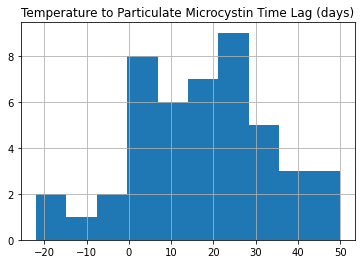

Temperature to Particulate Microcystin Time Lag (days)
count                                          46.000000     
mean                                           16.739130     
std                                            18.431175     
min                                           -22.000000     
25%                                             0.000000     
50%                                            14.000000     
75%                                            28.000000     
max                                            50.000000

In [80]:
#Temperature data
Tdeltas = sitelags('CTD Temperature (°C)', 'Particulate Microcystin (µg/L)')
Tdf = pd.DataFrame({'Temperature to Particulate Microcystin Time Lag (days)': Tdeltas}).astype('timedelta64[D]')
Tdf.hist()
plt.show()
Tdf.describe()

array([[<AxesSubplot:title={'center':'Dissolved Oxygen to Particulate Microcystin Time Lag (days)'}>]],
      dtype=object)

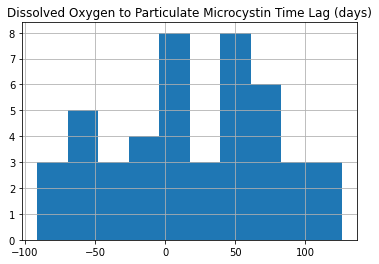

In [81]:
#Dissolved Oxygen Data
Odeltas = sitelags('CTD Dissolved Oxygen (mg/L)', 'Particulate Microcystin (µg/L)')
pd.DataFrame({'Dissolved Oxygen to Particulate Microcystin Time Lag (days)': Odeltas}).astype('timedelta64[D]').hist()

Particulate microcystin seems to reach its maximum value about two to three weeks after the peak yearly temperature, and does not seem to have a predictable relationship with dissolved oxygen.

## Distance from Shore to Site

Can we calculate the shortest distance from each site to the shoreline?

In [82]:
#Import Lake Erie shape file
erie_df = gpd.read_file('../data/raw/hydro_p_LakeErie/hydro_p_LakeErie.shp')

In [83]:
erie_df

HYDRO_P_  UIDENT  TYPE COUNTRY     NAMEEN              NAMESP    NAMEFR  \
0      3417  194002    16     CAN  Lake Erie  Lake Erie/Lac Érié  Lac Érié   
1      3418  563302    16     USA  Lake Erie  Lake Erie/Lac Érié  Lac Érié   

                                            geometry  
0  POLYGON ((-79.56224 42.85247, -79.55794 42.850...  
1  POLYGON ((-83.18933 42.09127, -83.17230 42.092...

<AxesSubplot:>

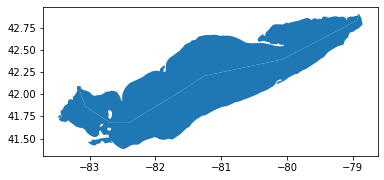

In [84]:
erie_df.plot()

In [85]:
#project to WGS-84 coordinates
erie_crs = erie_df.to_crs('WGS-84')
erie_crs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [86]:
#Select only the boundary of the lake
erie_pts = erie_crs.geometry.unary_union.boundary

<AxesSubplot:>

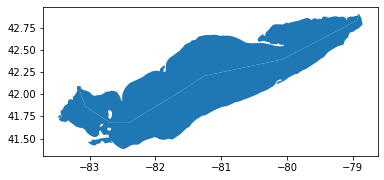

In [87]:
erie_crs.plot()

Shapely's nearest_point and distance methods can be used to generate the nearest euclidean distance to the boundary of the lake, which is stored in erie_pts. If we wish to calculate the actual distance in meters or miles we could do so using geopy's distance function, but for now that is not necessary. Also, such a calculation may not be very precise for reasons that are currently beyond my full understanding.

In [88]:
for i in surface.index:
    lat = surface.loc[i, 'Latitude (decimal deg)']
    long = surface.loc[i, 'Longitude (decimal deg)']
    p = Point(long, lat)
    surface.loc[i, 'Shore Distance (euc dis)'] = erie_pts.distance(p)

In [89]:
#check using mapsites to see if quartiles are properly identified
mapsites(surface, col='Shore Distance (euc dis)')

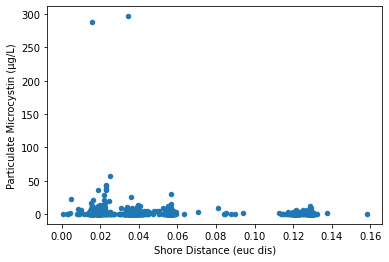

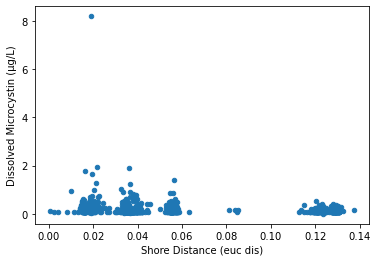

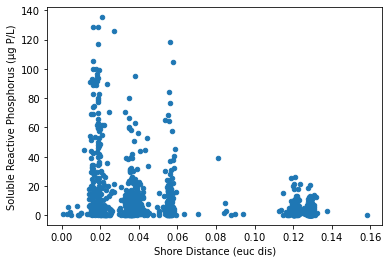

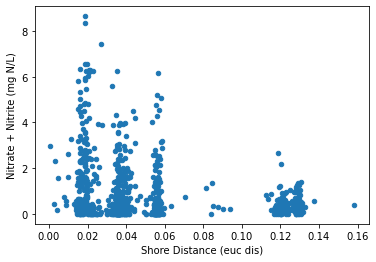

In [90]:
for col in ['Particulate Microcystin (µg/L)', 'Dissolved Microcystin (µg/L)', 'Soluble Reactive Phosphorus (µg P/L)', 
            'Nitrate + Nitrite (mg N/L)']:
    surface.plot(x='Shore Distance (euc dis)', y=col, kind='scatter')

We see similar trends in pollutant features vs shore distance as we did with distance to the Maumee river. Closer sites have greater fluctuations due to proximity to influxes of pollutants from runoff and river loading. As polluted waters diffuse out into the western basin they mix with purer lake water and are diluted.

In [91]:
#repeat for sites_df
for i in sites_df.index:
    lat = sites_df.loc[i, 'Latitude (decimal deg)']
    long = sites_df.loc[i, 'Longitude (decimal deg)']
    p = Point(long, lat)
    sites_df.loc[i, 'Shore Distance (euc dis)'] = erie_pts.distance(p)

## Export Data

In [92]:
#Overwrite old surface csv
surface.to_csv('../data/interim/surface.csv')
sites_df.to_csv('../data/interim/sites_df.csv')